# Topic Diversity of Published Translations

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

**Last Update: 24 January 2023**

[TASK](https://phabricator.wikimedia.org/T309603)

# Contents

1. [Overview](#Overview)
2. [Methodology](#Methodology)
3. [Overall Topic Diversity](#Overall-Topic-Diversity)
4. [Topic Diversity by Platform](#Topic-Diversity-by-Platform)
5. [Topic Diversity by Translation Activity](#Topic-Diversity-by-Translation-Activity) 
6. [Topic Diversity by User Experience](#Topic-Diversity-by-User-Experience)
7. [Topic Diversity by Language](#Topic-Diversity-by-Language)


# Overview

Content and Section Translation are used to translate Wikipedia articles across different languages. However, we don't have much visibility on the kinds of articles that are translated. We would like to have an understanding about the topics that are frequently translated, and those that are underrepresented.

In this analysis, we reviewed the diversity of topics across the following dimensions:
* Overall
* By Platform
* Translation Activity
* User Experience based on the user's edit count
* Language

Theses results will be useful in potentially informing the work on suggestions and community campaigns. They will also help define a baseline to track progess towards the following Key Result defined in the Language team's OKRs: "*Increase the diversity of topics translated with a 10% increase of translations for previously underrepresented topics*"

# Methodology

Published translation data comes from [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) and the topic data is based on the [Topic interest mapping model from ORES] (https://www.mediawiki.org/wiki/ORES?useskin=vector-2022#Topic_interest_mapping). 

Data reflects translations published from September 2021 through September 2022. The time frame was selected based on the availability of accurate topic data ( the topic dataset used for this analysis was last updated on September 2022) and to collect a large enough sample size to accurately review data on a per language basis.

Some other key notes about the data used for this analysis:
* Only content pages on Wikipedia projects are included.
* There are in total 64 topics, please refer to the [taxonomy](https://www.mediawiki.org/wiki/ORES/Articletopic?useskin=vector-2022) for detailed article topics. In this dataset, topics are broken down into "main topic" and "sub topic" based on the taxonomy.
* Topics that end in a asterisk * are catch-all categories. E.g. Media.Media* is a subcategory that includes aLL items that appear within Media .(Media.Book, Media.Entertainment, Media.Films, etc). It also includes any items that are generally related to Media but don't fit into the specific categories.
* One article may have multiple topics. We are counting edits per article topic. When topics are aggregated, it results in double counting of articles and makes the total edits larger than they are.


**Some Follow-Up Notes/Questions:**
* The analysis below reflects number of translations. Would if be worth looking at number of distinct users that have published translations for each topic?
* Should translations deleted be excluded from the analysis?
* Would it be worthwhile incorporting this dataset into Superset? 

In [511]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [512]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
     library(ggplot2)
    library(tidyverse)
    library(lubridate)
    # Tables:
    library(gt)
    library(gtsummary)
    # Misc
    library(dplyr, warn.conflicts = FALSE)
})

In [449]:
options(dplyr.summarise.inform = FALSE)

In [80]:
# pull published translations on Wikipedia content pages

query <- "
SELECT
   DATE_FORMAT(mwh.event_timestamp, 'yyyy-MM-dd') as `date`,
    mwh.wiki_db AS language,
    event_user_text AS user_name,
    mwh.revision_id AS revision_id,
    topics.topic,
    tc.main_topic,
    tc.sub_topic,
    event_user_registration_timestamp AS user_registration_date,
    event_user_revision_count,
    CASE WHEN array_contains(revision_tags, 'mobile app edit') THEN 'Mobile app' 
         WHEN array_contains(revision_tags, 'mobile web edit') THEN 'Mobile web' 
    ELSE 'Other' END AS platform,
    CASE WHEN (ARRAY_CONTAINS(revision_tags,'sectiontranslation') AND revision_parent_id > 0)  THEN 'expand an article'
         WHEN ((ARRAY_CONTAINS(revision_tags,'contenttranslation') OR 
        ARRAY_CONTAINS(revision_tags, 'sectiontranslation') OR 
        ARRAY_CONTAINS(revision_tags,'contenttranslaton-v2')) AND revision_parent_id = 0) THEN 'create new article'
  ELSE 'overwrite an article'
  END AS translation_activity
FROM
wmf.mediawiki_history mwh
INNER JOIN canonical_data.wikis cd 
    ON mwh.wiki_db = cd.database_code AND
    cd.database_group = 'wikipedia'
INNER JOIN isaacj.article_topics_outlinks topics ON (
  cd.database_code =  topics.wiki_db
  AND mwh.page_id = topics.pageid
-- only include topics with a confidence score above 0.15
  AND topics.score >= 0.5)
LEFT JOIN cchen.topic_component tc ON topics.topic = tc.topic 
WHERE 
    mwh.event_entity = 'revision'
    AND mwh.event_type = 'create' 
-- only content mainspace 
    AND mwh.page_namespace = 0
    AND (ARRAY_CONTAINS(revision_tags, 'sectiontranslation')
    OR ARRAY_CONTAINS(revision_tags, 'contenttranslation')
    OR ARRAY_CONTAINS(revision_tags, 'contenttranslation-v2'))
-- last snapshot where topic data was available
    AND mwh.snapshot = '2022-09'
    AND topics.snapshot = '2022-09'
-- last year of available data
    AND mwh.event_timestamp BETWEEN '2021-09-01' and '2022-09-31'
"

In [ ]:
cx_topics_data <- wmfdata::query_hive(query)

In [45]:
# save data
write.csv(cx_topics_data,
    file = 'Data/cx_topics_data.csv',
    row.names = FALSE
  ) 


In [515]:
# load in data
cx_topics_data <-
  read.csv(
    file = 'Data/cx_topics_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 


In [516]:
# reformat and clean data

cx_topics_data$date <- as.Date(cx_topics_data$date, format = "%Y-%m-%d")

# set factor levels
cx_topics_data$main_topic <- 
    factor(
    cx_topics_data$main_topic,
    levels = c("Geography", "Culture", "History_and_Society", "STEM"),
    labels = c("Geography", "Culture", "History and Society", "STEM")
  )

# set factor level and rename platform
# note there is no specific tag for desktop in mediawiki; however, the majority of these instances are desktop. This may include some API type edit tools but they are rare.
cx_topics_data$platform <- 
    factor(
    cx_topics_data$platform,
    levels = c("Mobile web", "Other"),
    labels = c("Mobile Web", "Desktop")
  )

# Overall Topic Diversity 

## Overall topic diversity by Main Topic

In [517]:
cx_topics_bymaintopic <- cx_topics_data %>%
    group_by(main_topic) %>%
    summarise(n_translations = n_distinct(revision_id)) %>%
   mutate(prop_translations = paste0(round(n_translations / sum(n_translations) * 100, 1), "%"))  %>%
    arrange(desc(prop_translations)) 
   
cx_topics_bymaintopic

main_topic          n_translations prop_translations
1 Geography           198823         41%              
2 Culture             173252         35.7%            
3 History and Society  60080         12.4%            
4 STEM                 53190         11%

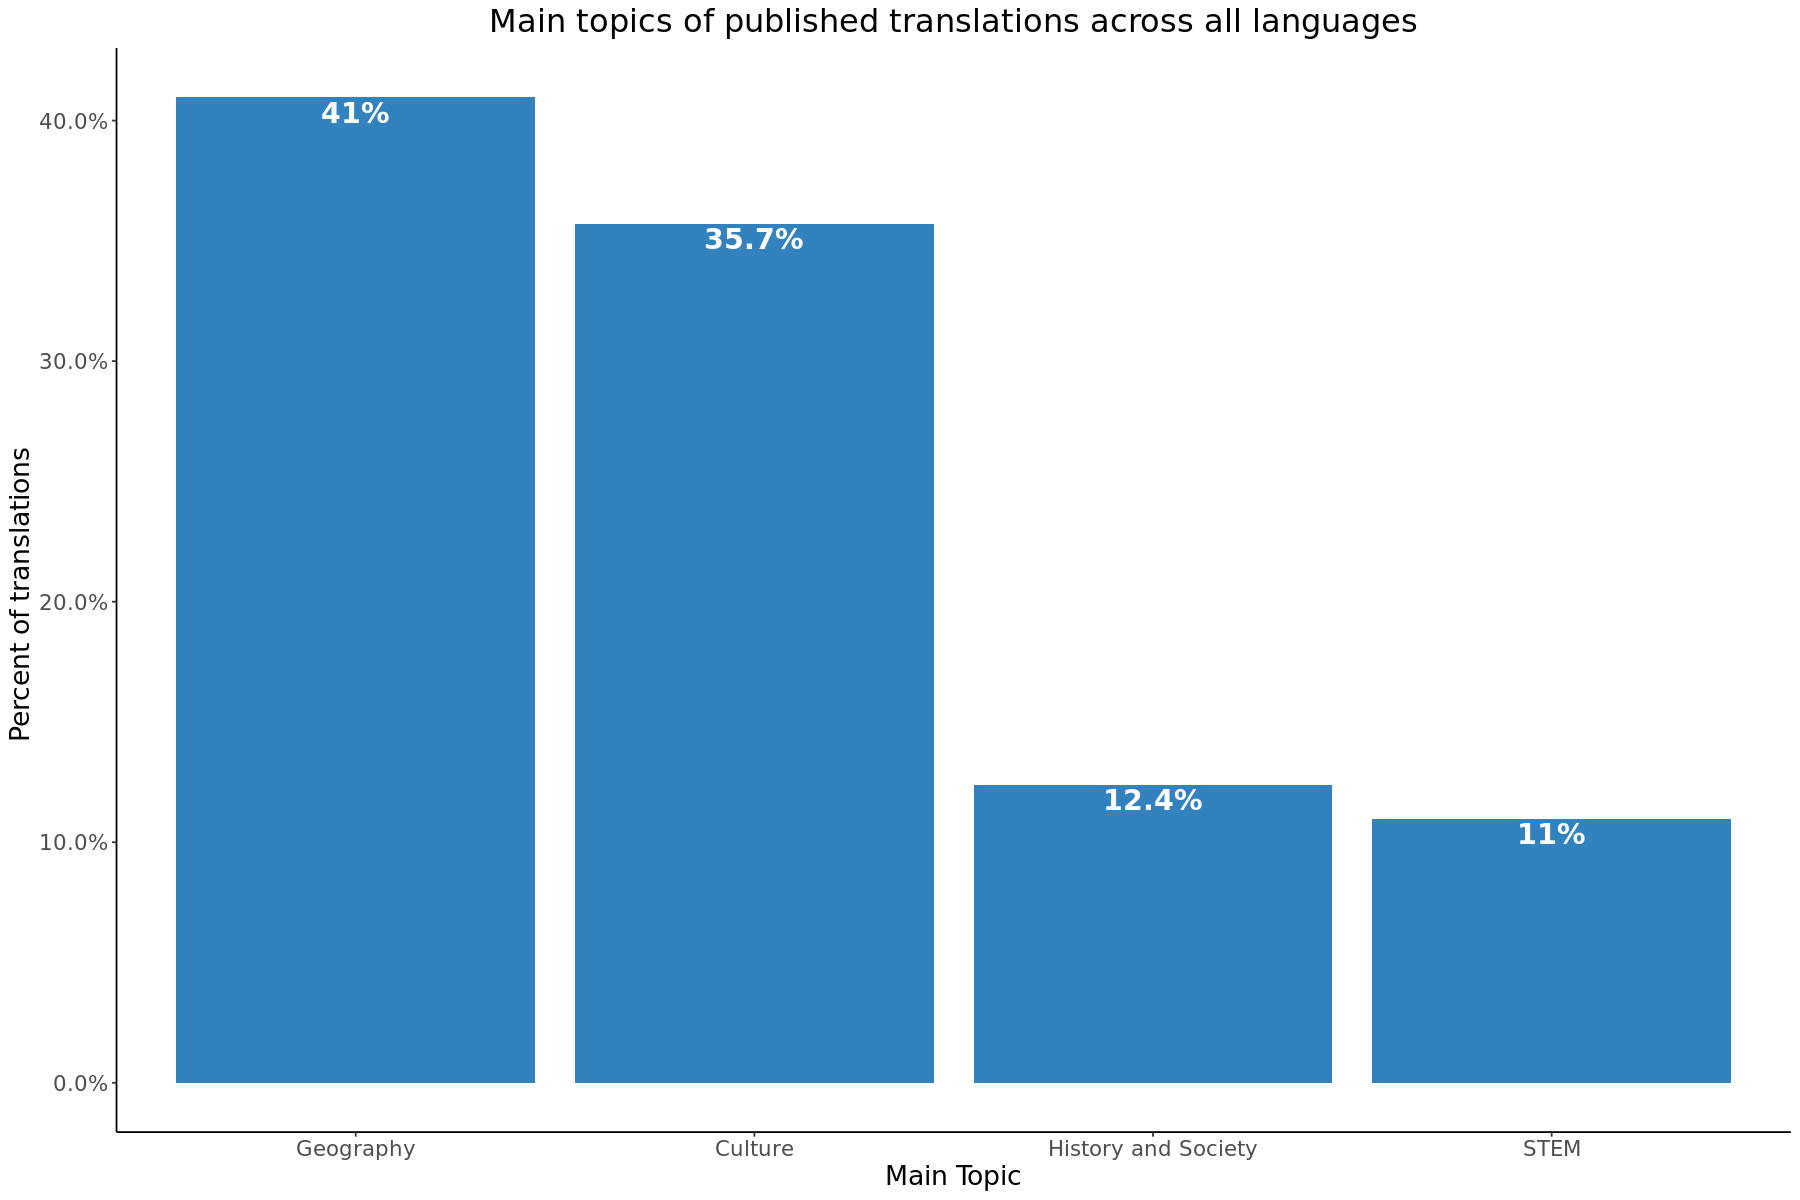

In [518]:
options(repr.plot.width = 15, repr.plot.height = 10)

# proportion of translations
p <- cx_topics_bymaintopic  %>%
    ggplot(aes(x= main_topic, y = n_translations / sum(n_translations))) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    geom_text(aes(label = paste(prop_translations), fontface=2), vjust=1.2, size = 6, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Main Topic",
          title = "Main topics of published translations across all languages")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_bymaintopic.png", p, width = 16, height = 8, units = "in", dpi = 300)

Geography and Culture are the most frequently translated topics, while History and Society and STEM are more underrepresented topic across all published translations. 

This is similar to trends we've observed for articles created without content translation except that Culture articles are slightly more frequently edited than Geography articles for non-translation edits. For reference, see the edits topics [dashboard](https://superset.wikimedia.org/superset/dashboard/p/WRLqO3xvYEx/).

In [105]:
cx_topics_bymaintopic_byday <- cx_topics_data %>%
    group_by(date, main_topic) %>%
    summarise(n_translations = n_distinct(revision_id), .groups = 'drop') %>%
   mutate(prop_translations = paste0(round(n_translations / sum(n_translations) * 100, 2), "%"))  



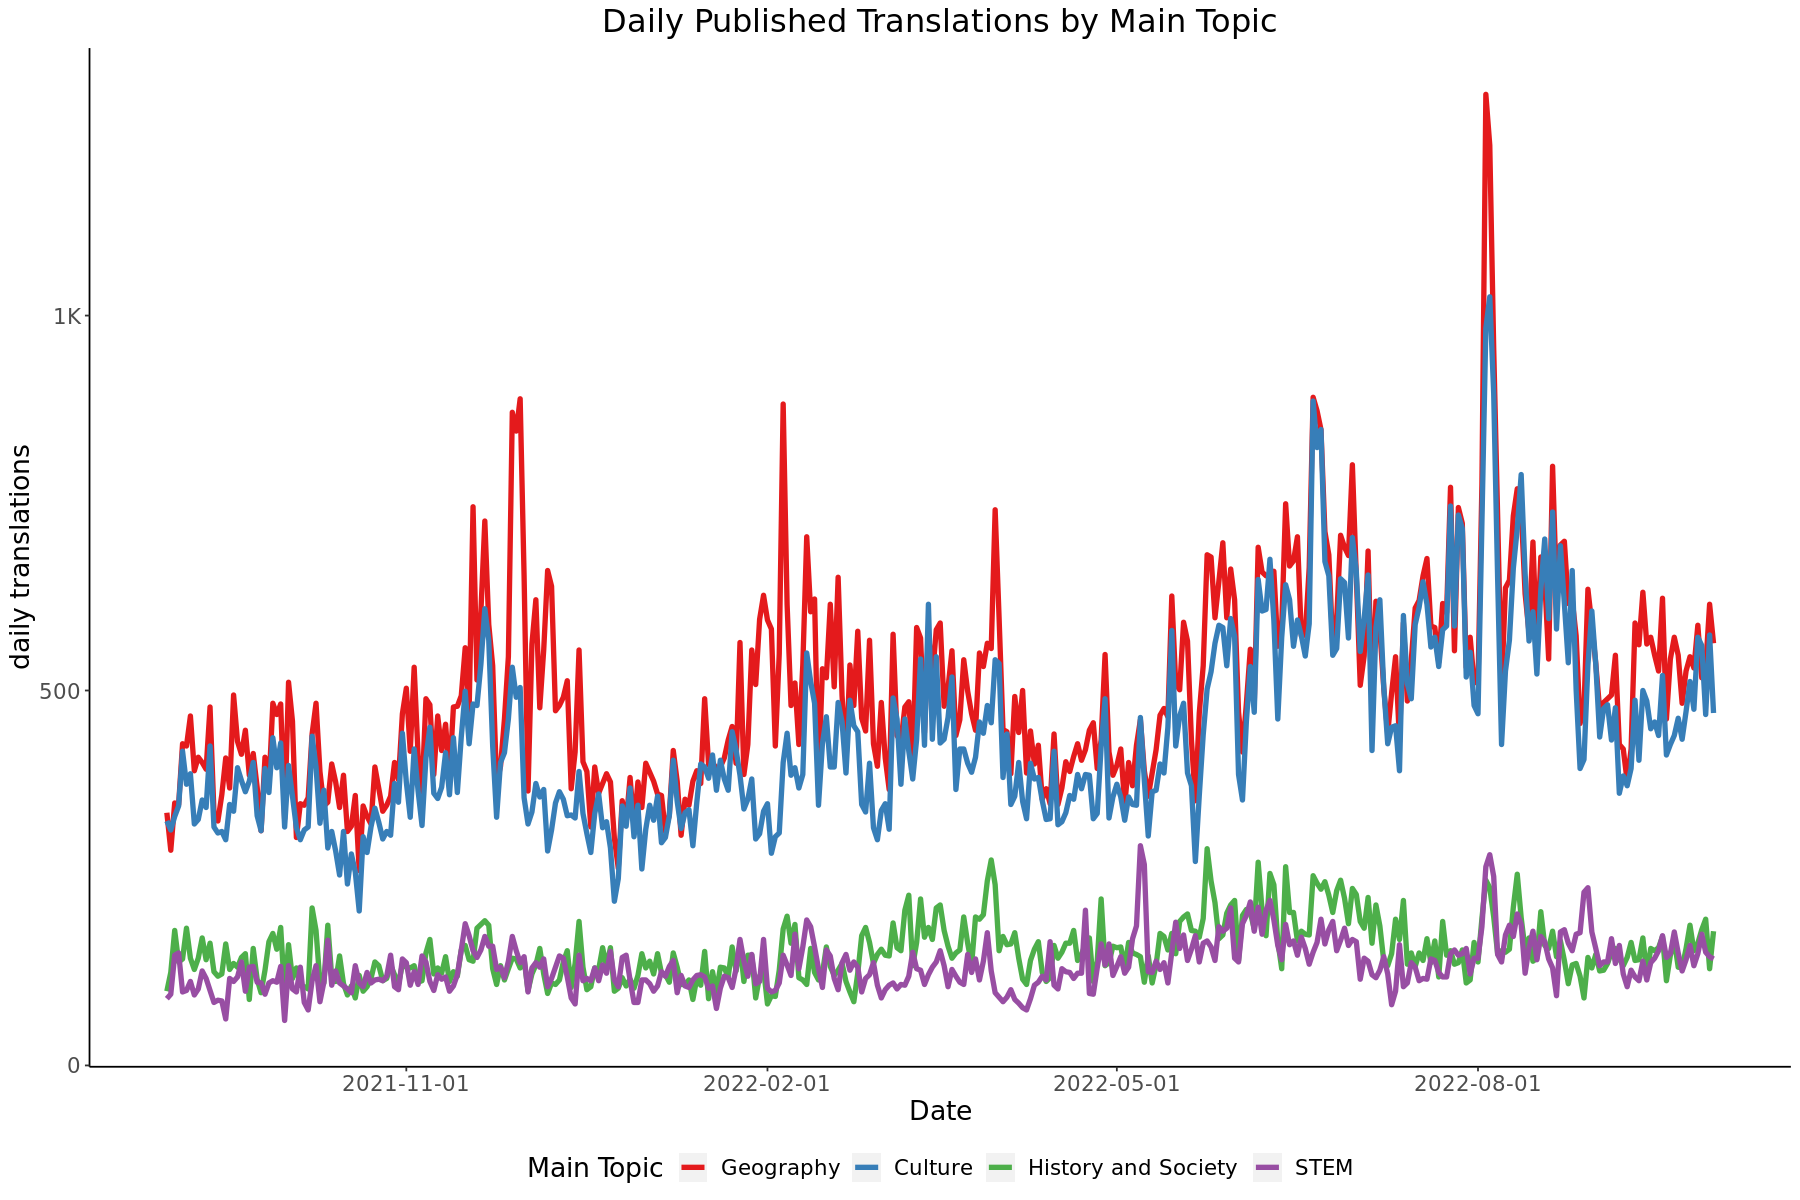

In [507]:
p <- cx_topics_bymaintopic_byday %>%
    ggplot(aes(x= date, y = n_translations , color = main_topic)) +    
    geom_line(size =1.5) +
    scale_y_continuous("daily translations", labels = polloi::compress) +
    scale_x_date("Date", date_breaks = "3 months") +
    scale_color_manual(values= c('#e41a1c','#377eb8', '#4daf4a', '#984ea3'), name = "Main Topic")  +
  labs(title = "Daily Published Translations by Main Topic") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 


ggsave("Figures/cx_topics_bymaintopic_byday.png", p, width = 16, height = 8, units = "in", dpi = 300) 

p

In [ ]:
Geography has consistently been the most frequently translated topic over the past year.

## Overall topic diversity by sub topic

In [520]:
cx_topics_bysubtopic <- cx_topics_data %>%
    group_by(main_topic, sub_topic) %>%
    summarise(n_translations = n_distinct(revision_id), .groups = 'drop') %>%
   mutate(prop_translations = paste0(round(n_translations / sum(n_translations) * 100, 2), "%")) %>%
    arrange(desc(prop_translations)) 
   

In [521]:
# order target languages based on factor levels

lvls <- as.character(cx_topics_bysubtopic$sub_topic)[order(cx_topics_bysubtopic$n_translations)]
cx_topics_bysubtopic$sub_topic<- factor(cx_topics_bysubtopic$sub_topic,levels=lvls)

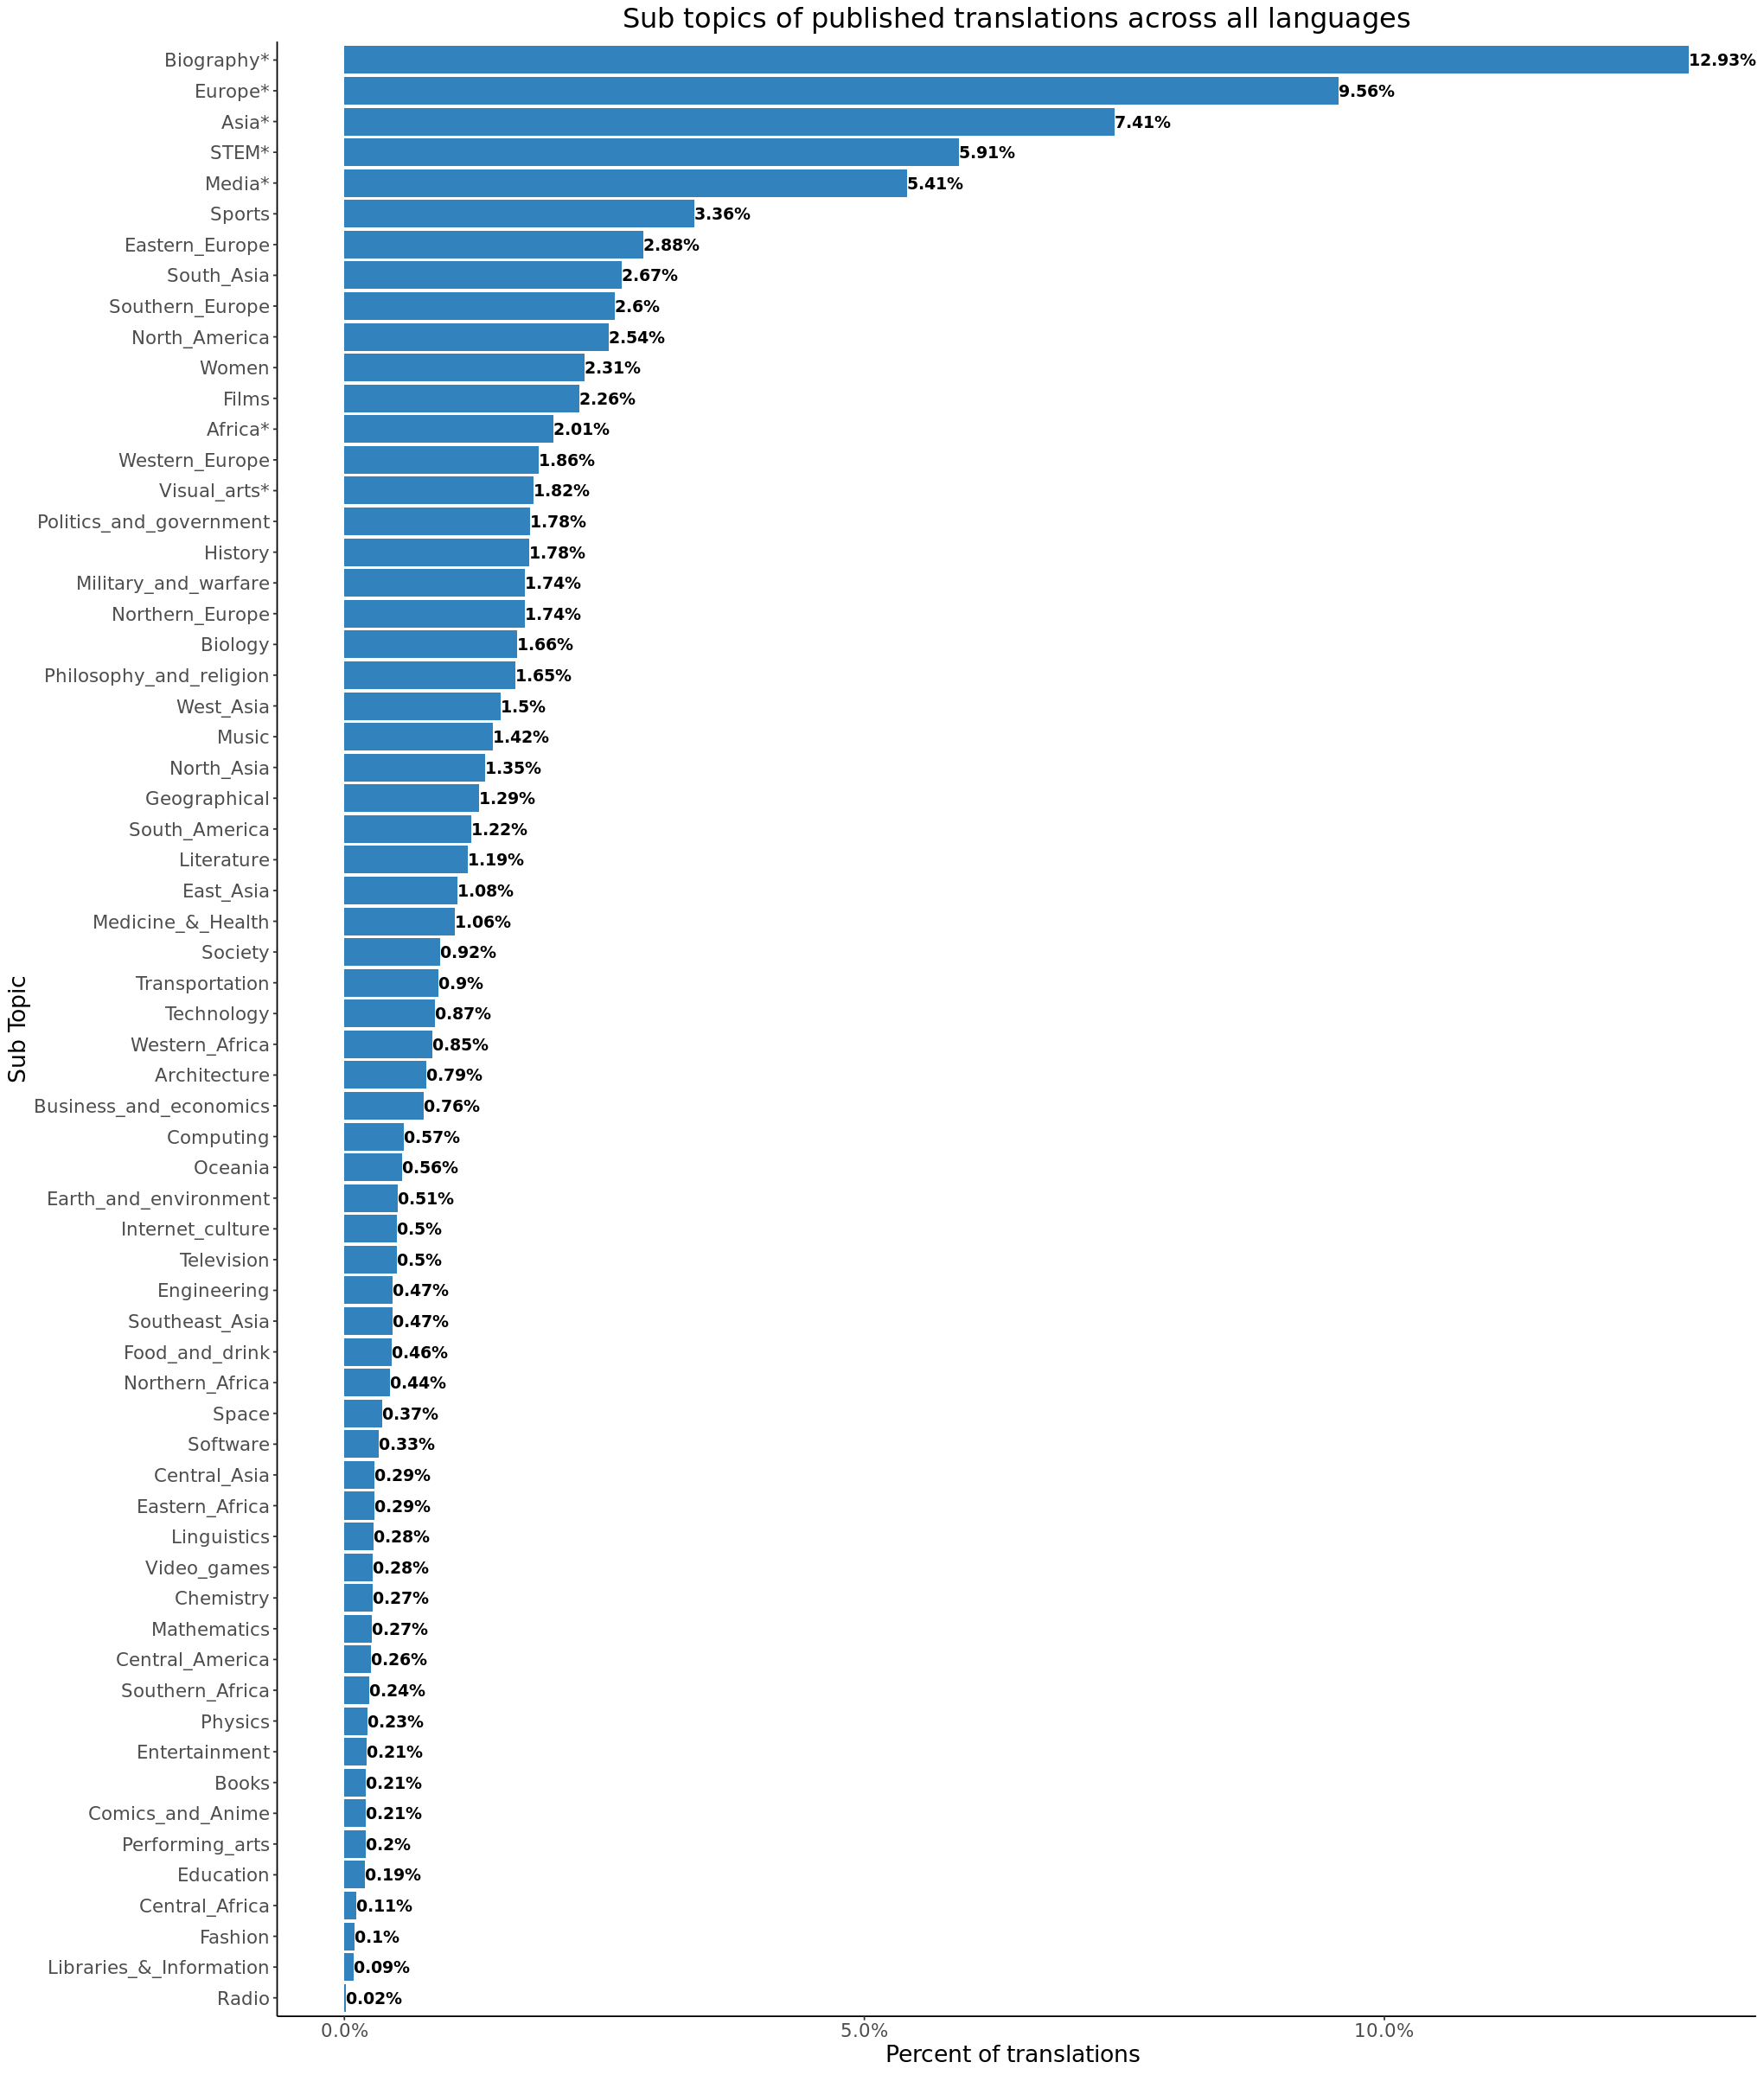

In [523]:
options(repr.plot.width = 17, repr.plot.height = 20)

# proportion of translations
p <- cx_topics_bysubtopic  %>%
    ggplot(aes(x= sub_topic, y = n_translations / sum(n_translations))) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    coord_flip() +
    geom_text(aes(label = paste(prop_translations), fontface=2), hjust=-0, size = 4, color = "black") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Sub Topic",
          title = "Sub topics of published translations across all languages")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_bysubtopic.png", p, width = 16, height = 8, units = "in", dpi = 300)

When looking at sub-topics, there are a 35 sub-topics that represent under 1% of published translations. Many of these are STEM topics such as Chemistry and Mathematics but there are also a few Geography topics that are underepresented such as Central America and Southern Africa. The chart above shows the proportion of published translations across all identifed sub-topics. 


# Topic Diversity by Platform

## Topic diversity by main topic and platform

In [502]:
cx_maintopics_byplatform <- cx_topics_data %>%
    group_by(platform, main_topic) %>%
    summarise(n_translations = n_distinct(revision_id)) %>%
   mutate(prop_translations = round(n_translations / sum(n_translations), 2))  %>%
    arrange(desc(platform, prop_translations)) 
   
cx_maintopics_byplatform

platform   main_topic          n_translations prop_translations
1 Desktop    Geography           193435         0.41             
2 Desktop    Culture             170133         0.36             
3 Desktop    History and Society  57751         0.12             
4 Desktop    STEM                 52264         0.11             
5 Mobile Web Geography             5418         0.46             
6 Mobile Web Culture               3131         0.27             
7 Mobile Web History and Society   2329         0.20             
8 Mobile Web STEM                   928         0.08

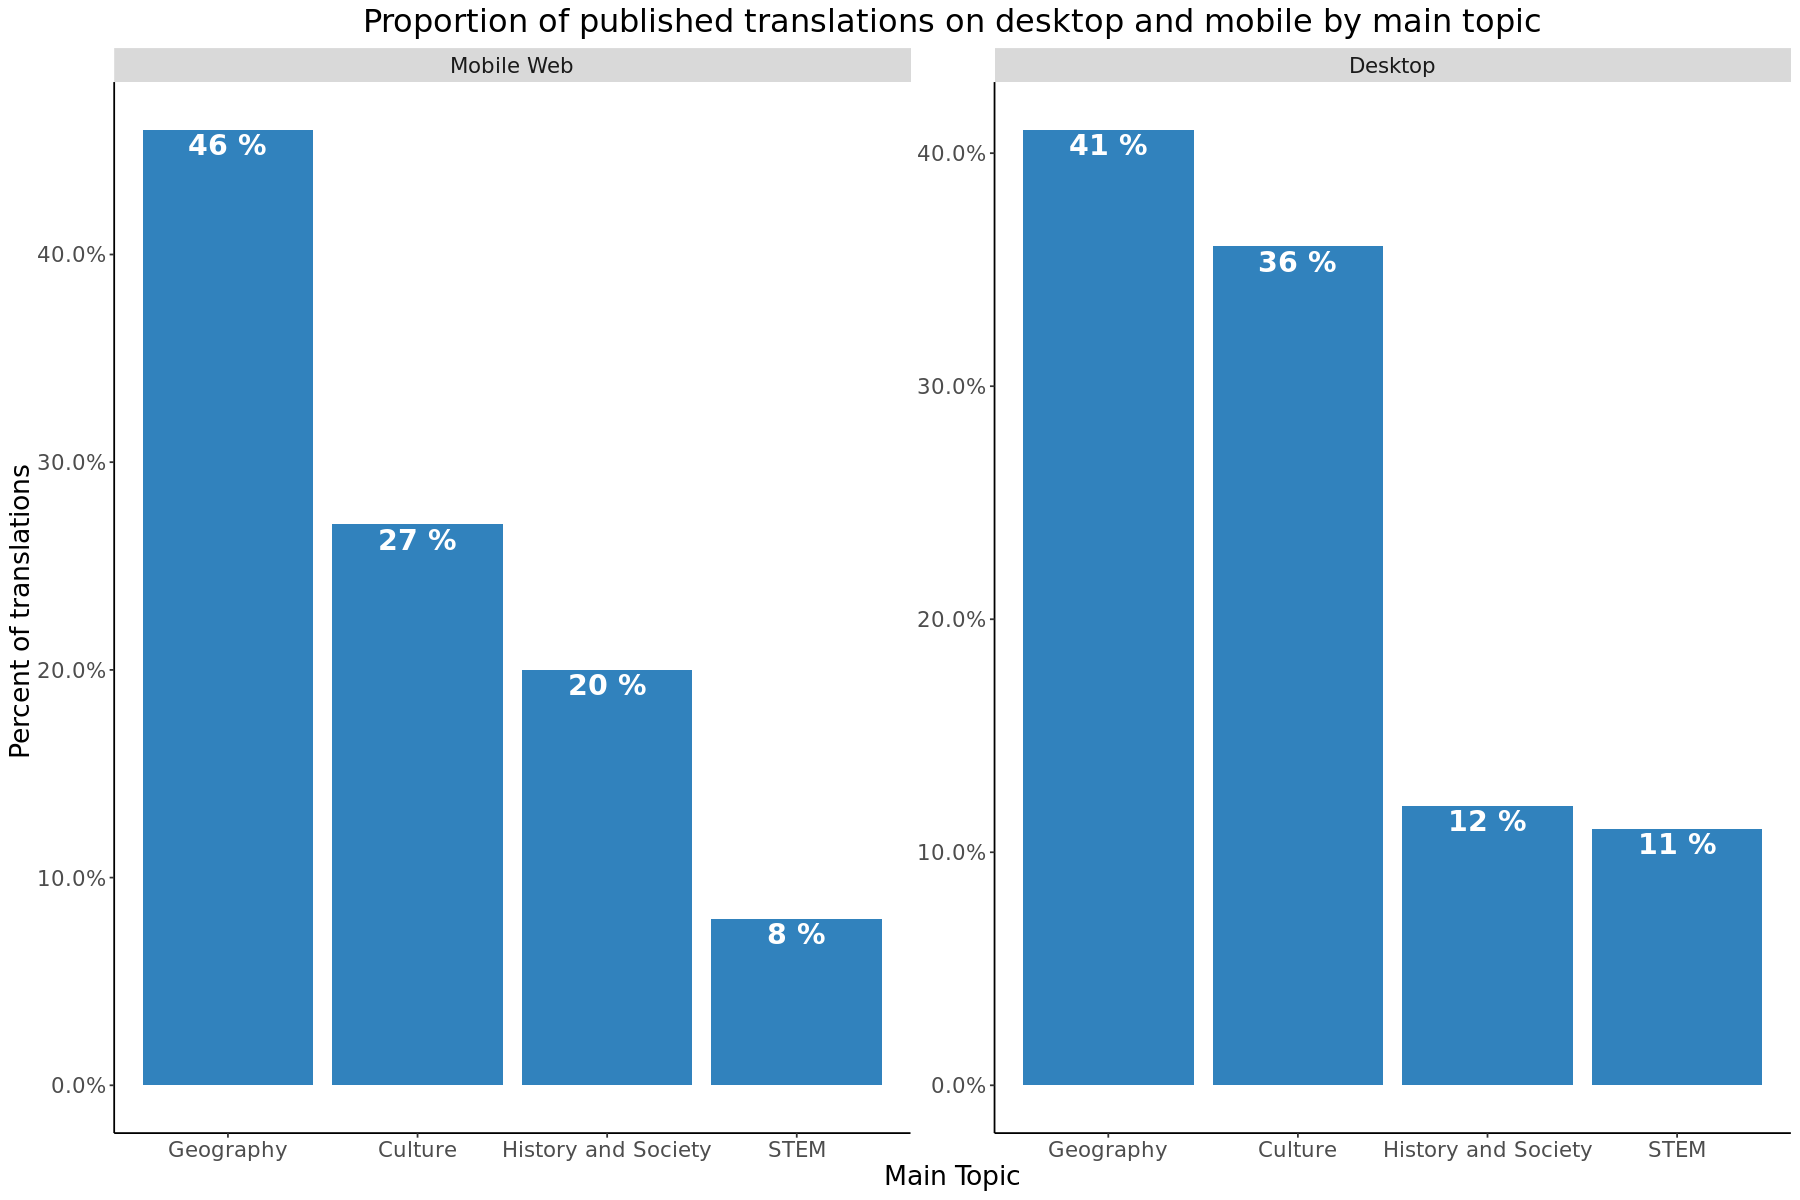

In [503]:
# Chart by Platform
options(repr.plot.width = 15, repr.plot.height = 10)
# proportion of translations
p <- cx_maintopics_byplatform %>%
    ggplot(aes(x= main_topic, y = prop_translations)) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    facet_wrap(~platform, scales = 'free_y') +
    geom_text(aes(label = paste(prop_translations* 100, "%"), fontface=2), vjust=1.2, size = 6, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Main Topic",
          title = "Proportion of published translations on desktop and mobile by main topic")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_byplatform.png", p, width = 16, height = 8, units = "in", dpi = 300)

By platform, Geography is the most frequently translated topic across both platforms. Culture is the second most translated topic on each platform; however, there are more translations on this topic on desktop compared to mobile web.

## Topic diversity by sub topic and translation activity

In [504]:
cx_topics_bysubtopic_platform <- cx_topics_data %>%
    group_by(platform, sub_topic) %>%
    summarise(main_topic = first(main_topic),
        n_translations = n_distinct(revision_id)) %>%
   mutate(prop_translations = n_translations / sum(n_translations))  %>%
    arrange(desc(n_translations)) 


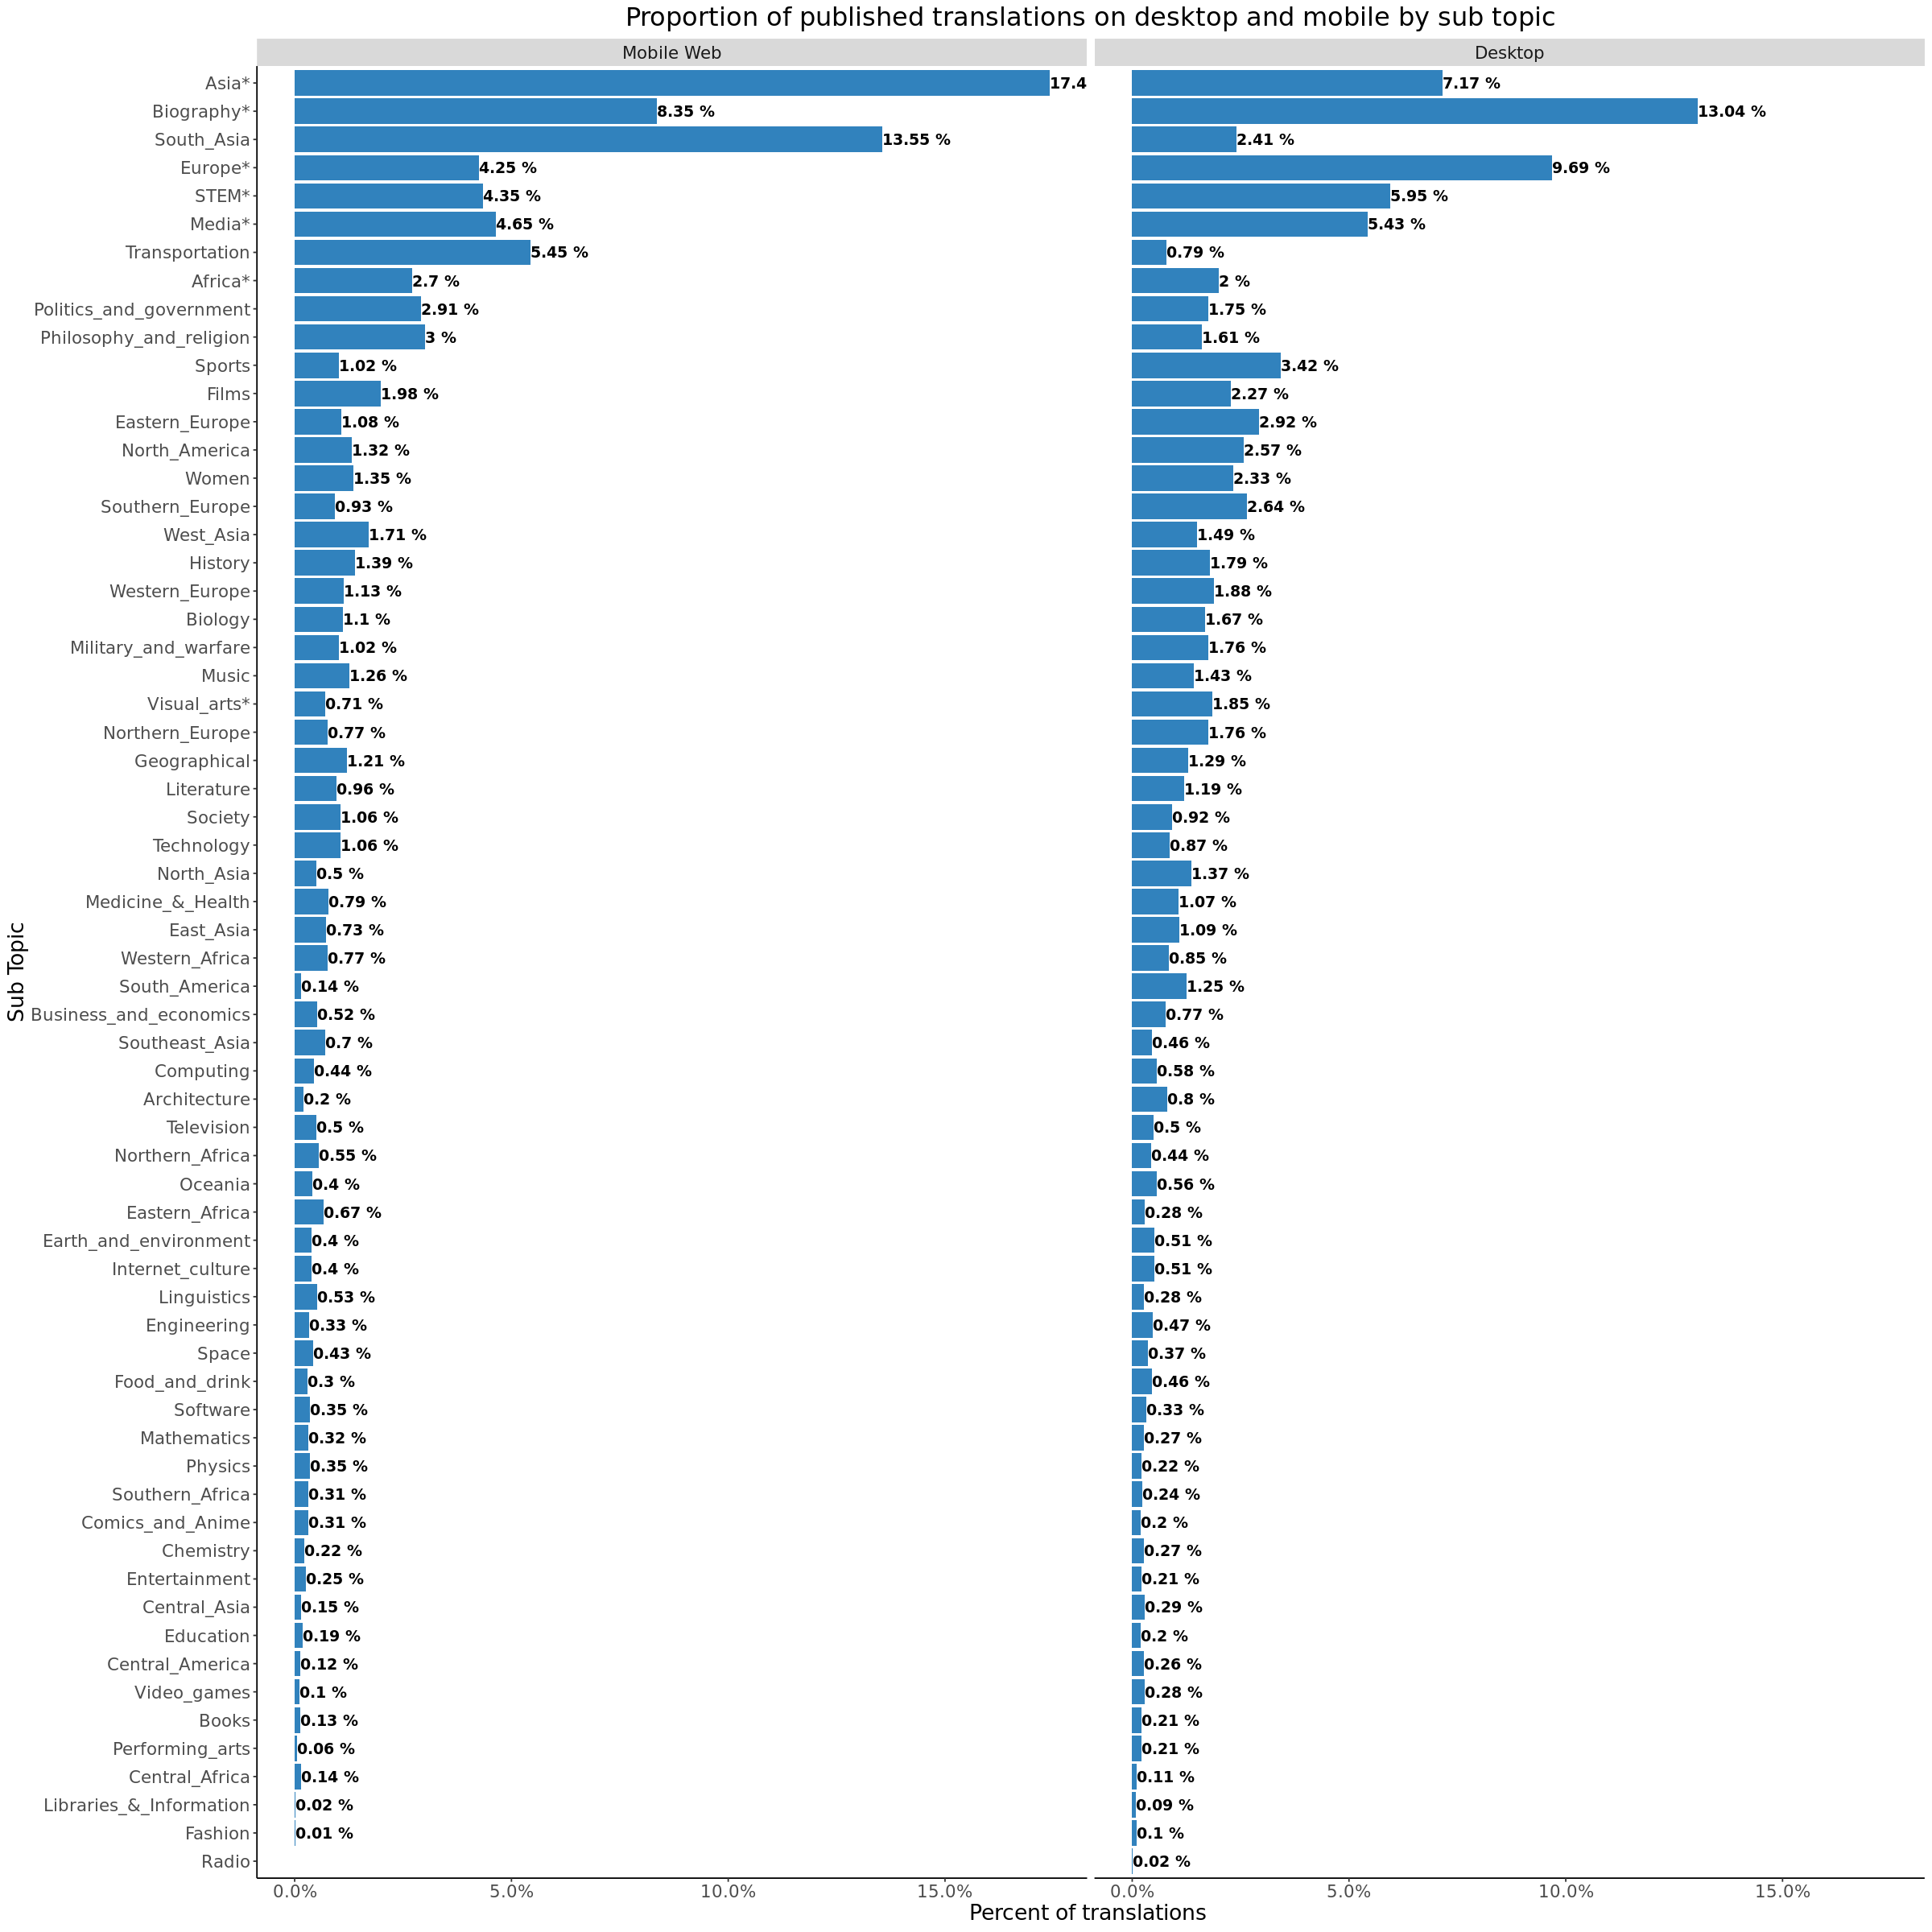

In [505]:
options(repr.plot.width = 20, repr.plot.height = 20)

# proportion of translations
p <- cx_topics_bysubtopic_platform  %>%
   ggplot(aes(x= reorder(sub_topic, prop_translations), y = prop_translations)) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    facet_wrap(~ platform)  +
    coord_flip() +
    geom_text(aes(label = paste(round(prop_translations * 100, 2), "%"), fontface=2), hjust=-0, size = 4, color = "black") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Sub Topic",
          title = "Proportion of published translations on desktop and mobile by sub topic")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_byplatform.png", p, width = 16, height = 8, units = "in", dpi = 300)

Th frequency of translations across the various sub topics is mostly consistent between desktop and mobile with a few notable exceptions:
* The are more Asia and South Asia translated topics on mobile compared to desktop.
* There are more Biography translated topics on desktop compared to mobile.

# Topic Diversity by Translation Activity

## Topic diversity by main topic and translation activity

In [382]:
cx_maintopics_byactivity <- cx_topics_data %>%
    group_by(translation_activity, main_topic) %>%
    summarise(n_translations = n_distinct(revision_id)) %>%
    mutate(prop_translations = round(n_translations / sum(n_translations), 2)) %>%
    arrange(desc(translation_activity, prop_translations)) 
   
cx_maintopics_byactivity 

translation_activity main_topic          n_translations prop_translations
1  overwrite an article Geography            17398         0.40             
2  overwrite an article Culture              14316         0.33             
3  overwrite an article History and Society   5779         0.13             
4  overwrite an article STEM                  6366         0.15             
5  expand an article    Geography             3241         0.48             
6  expand an article    Culture               1631         0.24             
7  expand an article    History and Society   1394         0.21             
8  expand an article    STEM                   503         0.07             
9  create new article   Geography           178268         0.41             
10 create new article   Culture             157343         0.36             
11 create new article   History and Society  52913         0.12             
12 create new article   STEM                 46329         0.11

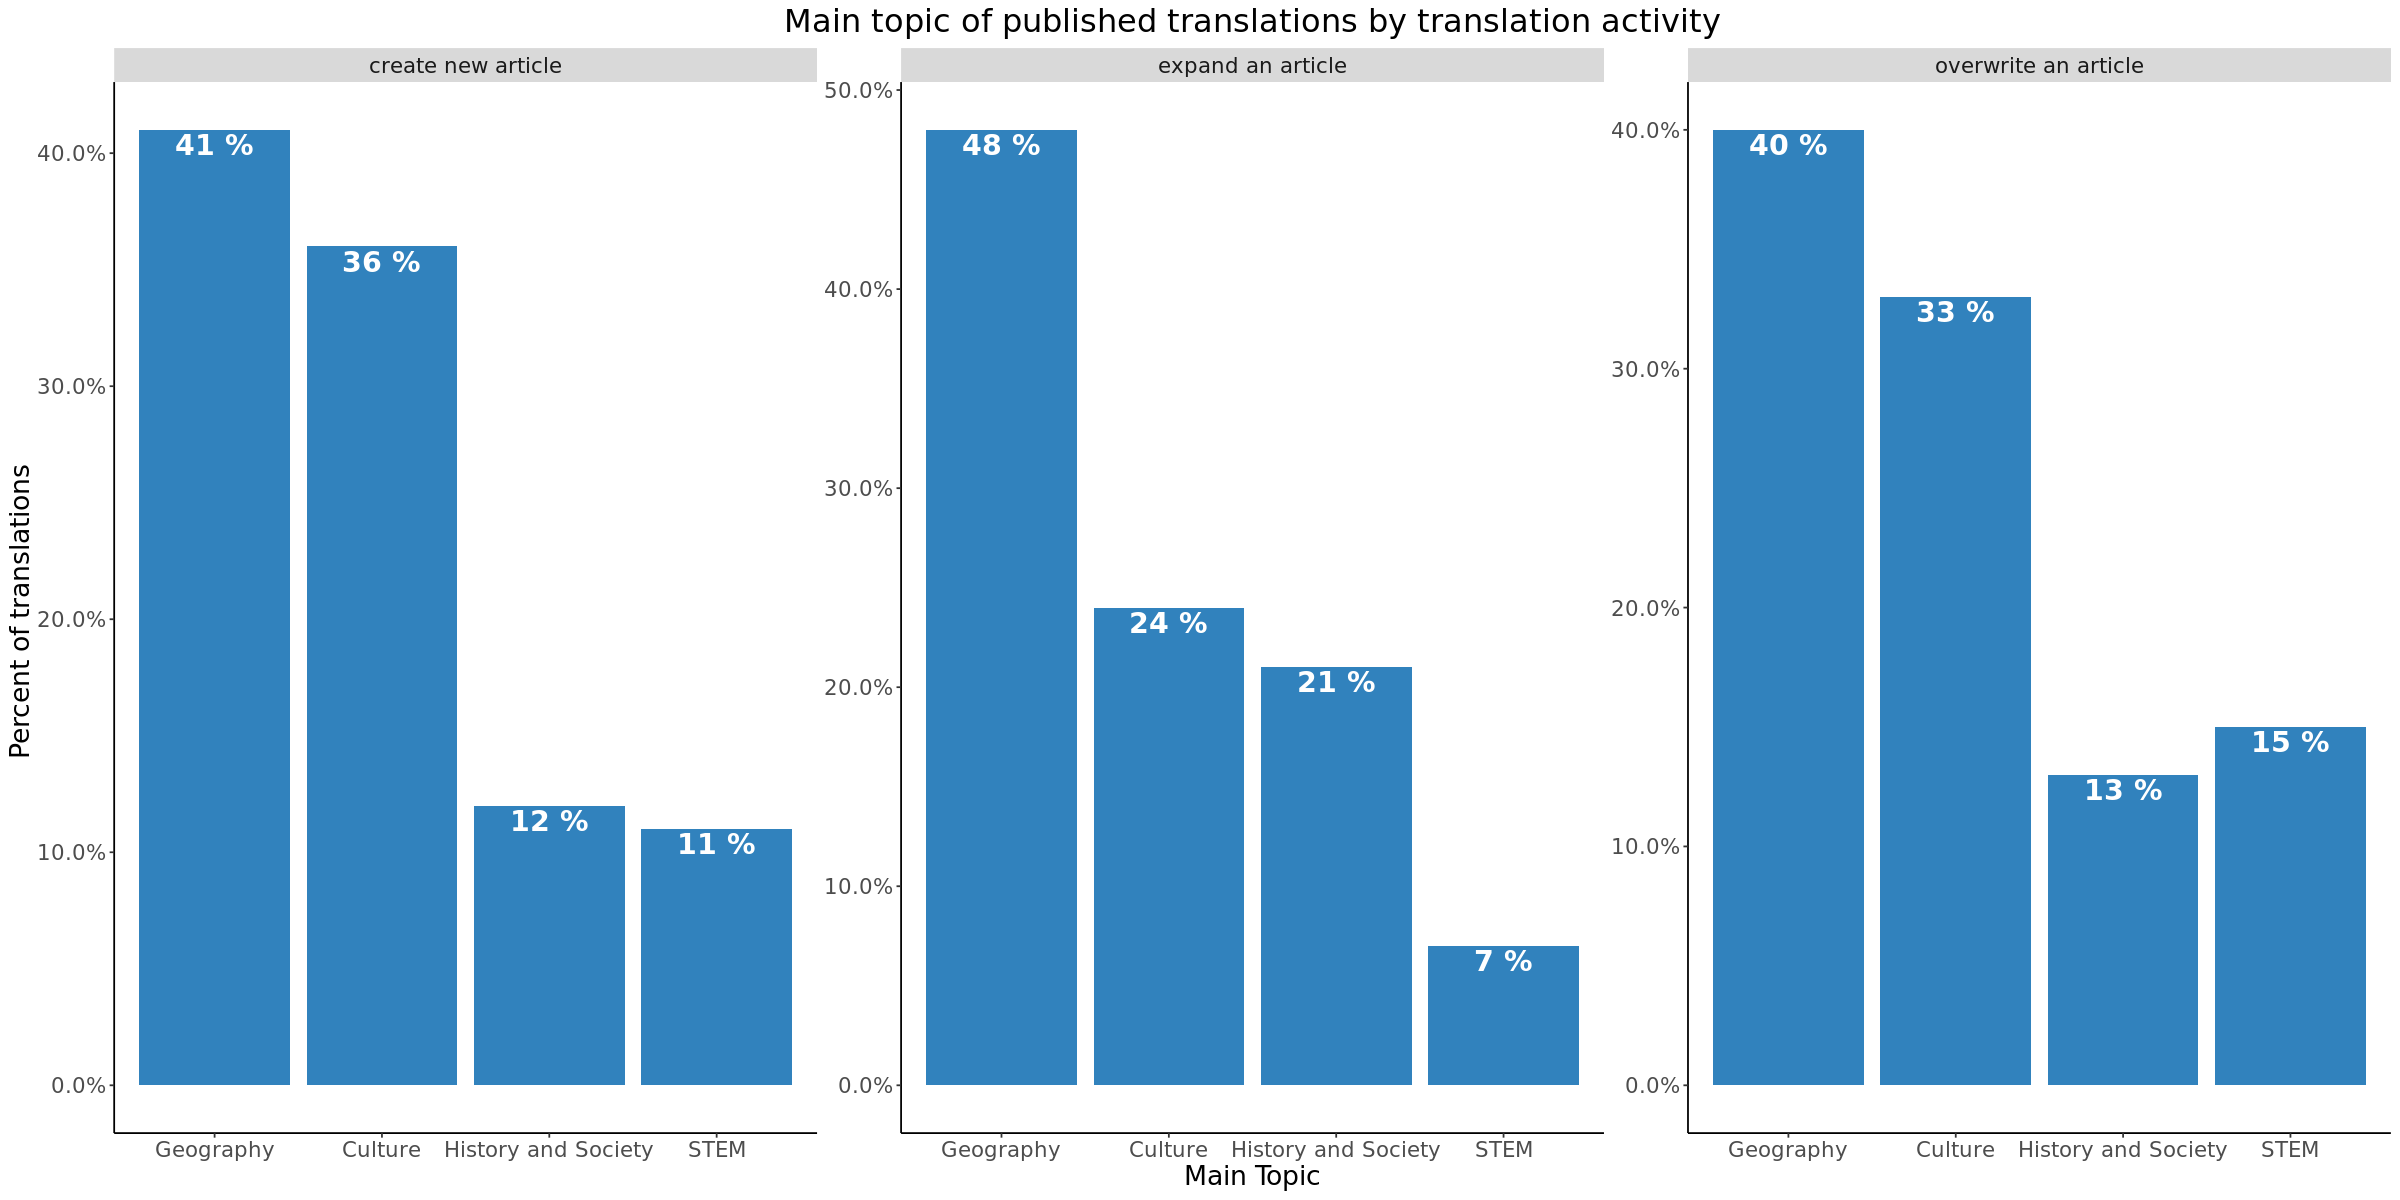

In [490]:
## Chart translation type by main topic

options(repr.plot.width = 20, repr.plot.height = 10)
# proportion of translations
p <- cx_maintopics_byactivity   %>%
    ggplot(aes(x= main_topic, y = prop_translations)) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    facet_wrap(~translation_activity, scales = 'free_y') +
    geom_text(aes(label = paste(prop_translations * 100, "%"), fontface=2), vjust=1.2, size = 6, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Main Topic",
          title = "Main topic of published translations by translation activity")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_byactivity.png", p, width = 16, height = 8, units = "in", dpi = 300)

Geography is the most frequently translated topic across all three translation activities including translations that create a new article or expand a new article. Some other notable trends:
* Translations that expand an article are used less frequently (24%) for Culture related topics compated to translations that create a new article (36%) or overwrite an article (33%). However, translations that expan and article are used more frequently for History and Society Related topics (21%) compared to translations that create a new article (12%) 



## Topic diversity by sub topic and translation activity

In [387]:
cx_topics_bysubtopic_activity <- cx_topics_data %>%
    group_by(translation_activity, sub_topic) %>%
    summarise(main_topic = first(main_topic),
        n_translations = n_distinct(revision_id)) %>%
   mutate(prop_translations = n_translations / sum(n_translations))  %>%
    arrange(desc(n_translations)) 


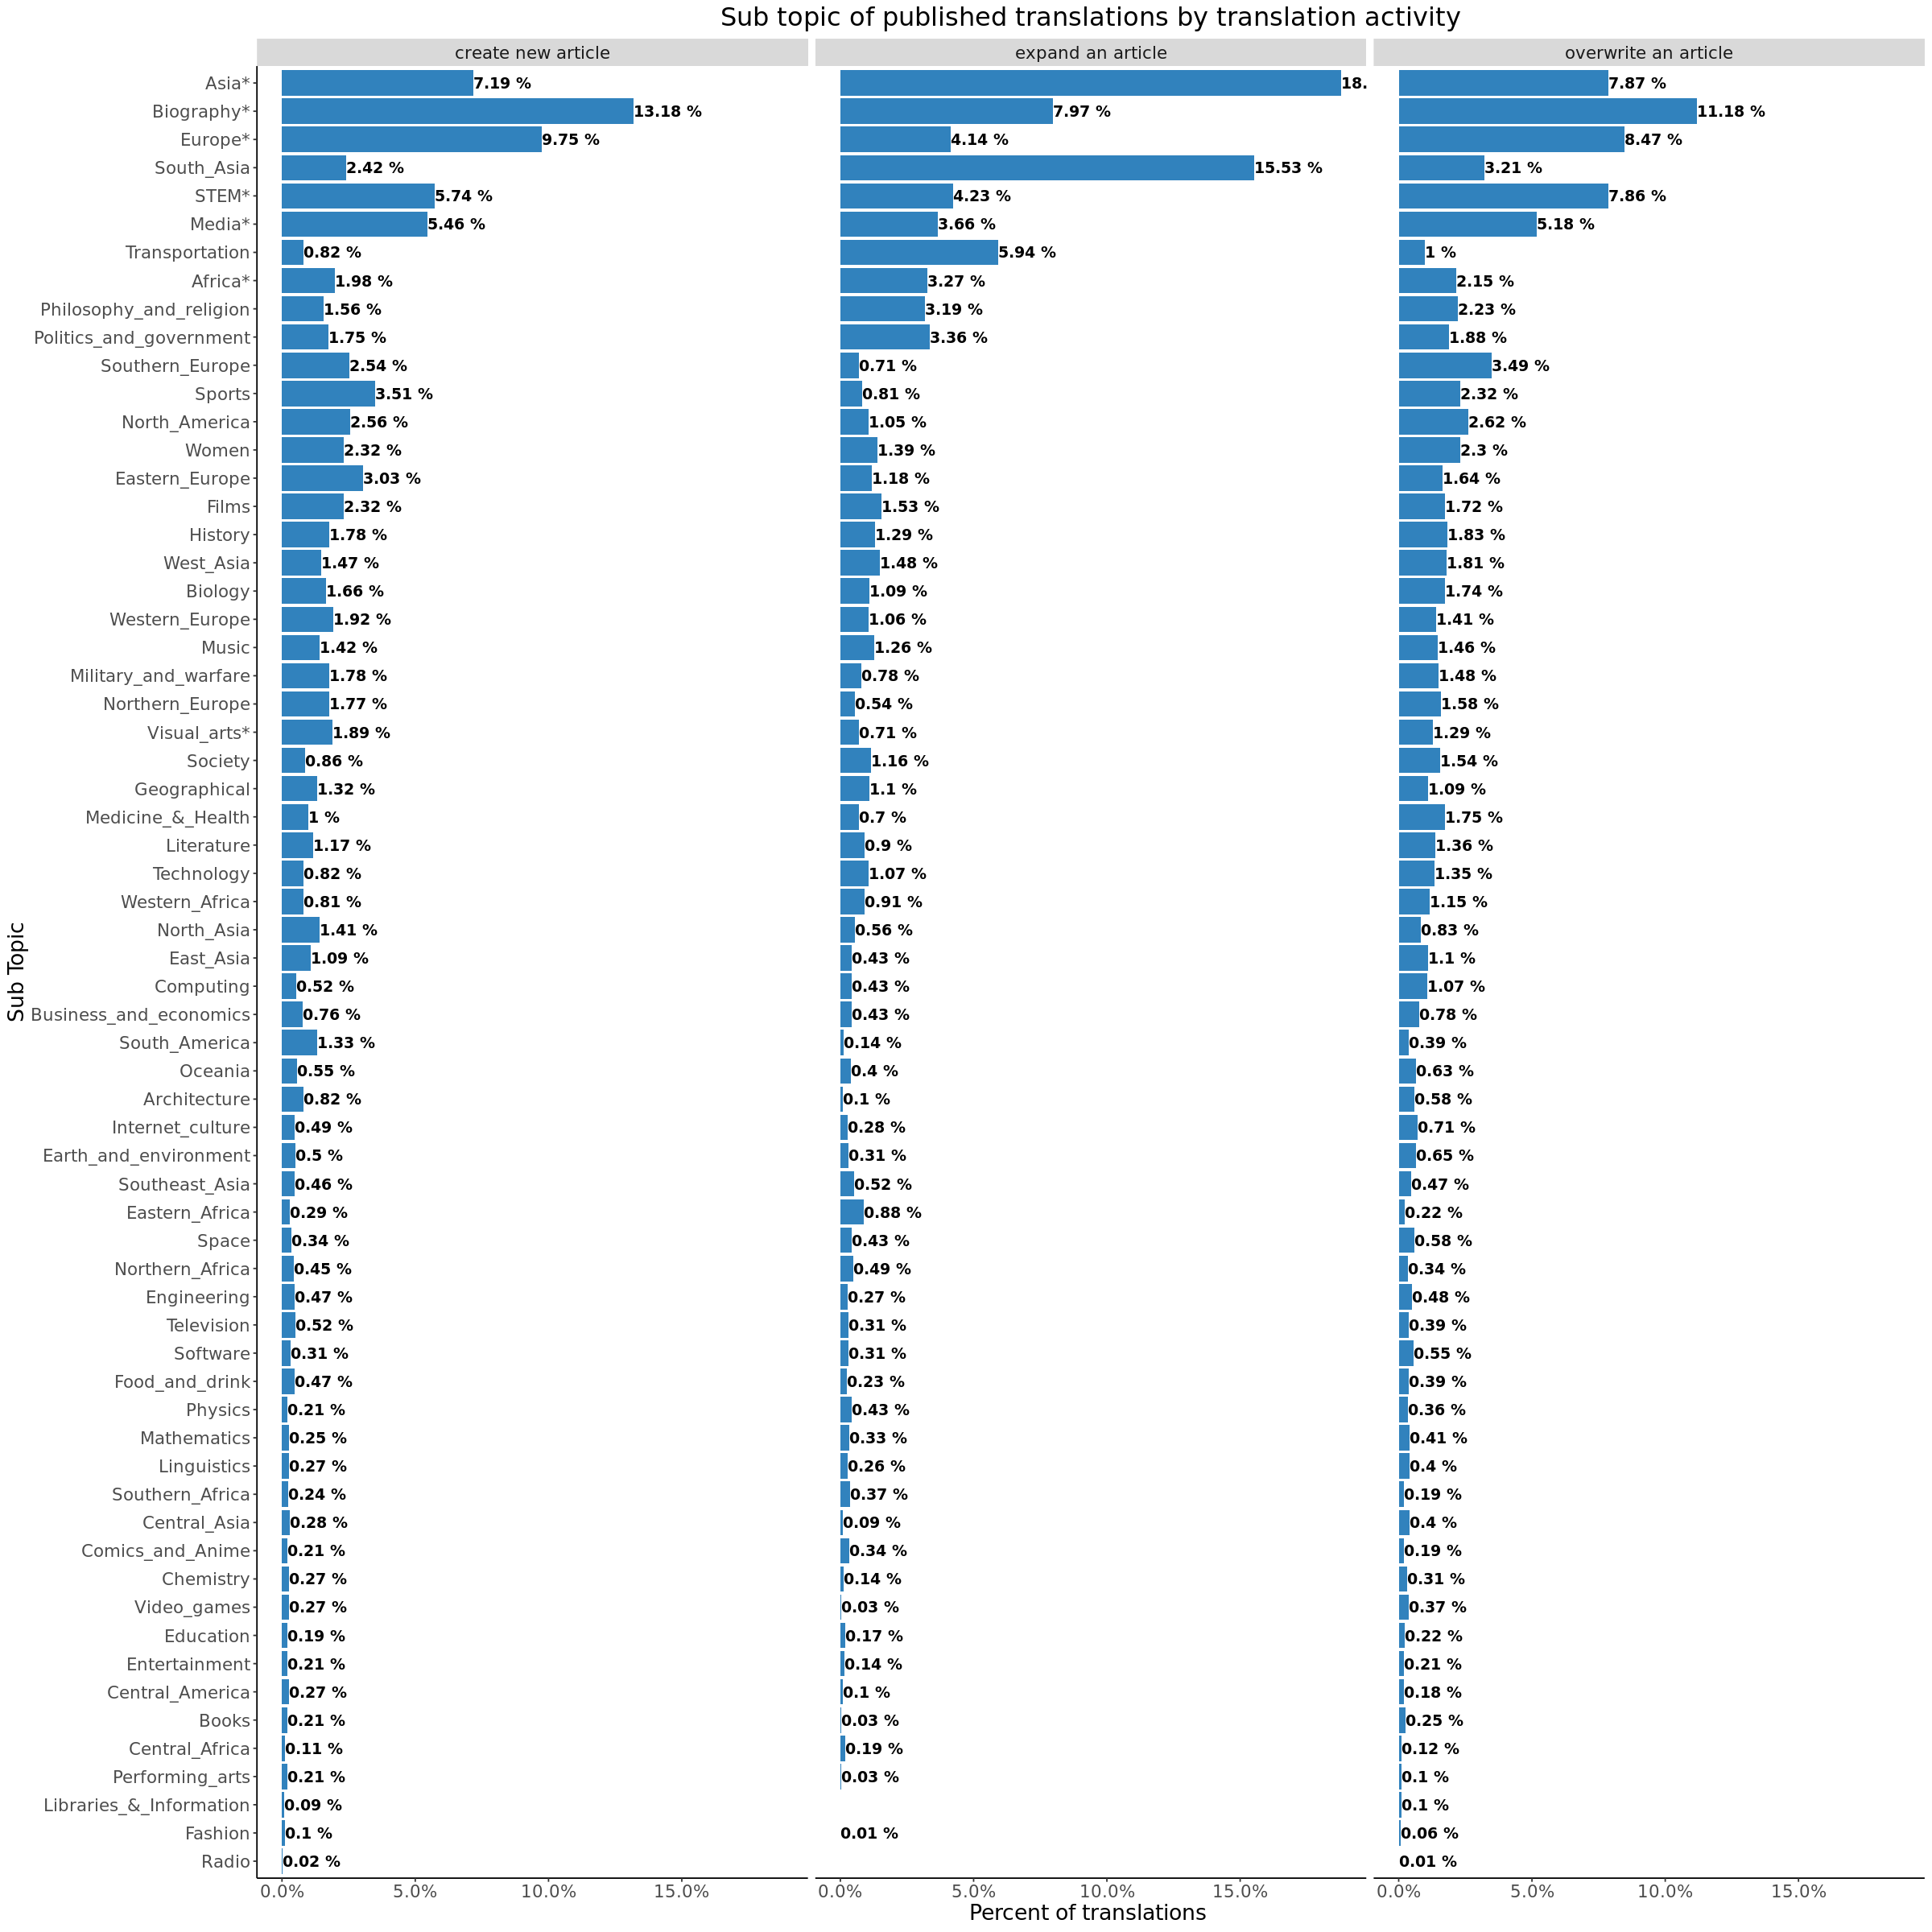

In [491]:
options(repr.plot.width = 20, repr.plot.height = 20)

# proportion of translations
p <- cx_topics_bysubtopic_activity   %>%
   ggplot(aes(x= reorder(sub_topic, prop_translations), y = prop_translations)) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    facet_wrap(~ translation_activity)  +
    coord_flip() +
    geom_text(aes(label = paste(round(prop_translations * 100, 2), "%"), fontface=2), hjust=-0, size = 4, color = "black") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Sub Topic",
          title = "Sub topic of published translations by translation activity")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_bysubtopic_activity .png", p, width = 16, height = 8, units = "in", dpi = 300)

Translation activity does not appear to signficantly impact the proportion of translations by sub topic. Some differences include:
* Asia and South Asia related topics are more frequently translated by translations that expand an article, while Biography related topics are more frequently translated by translations that create an article.
* This is similar to the trend we observed for sub topic by platform in the section above. There are more Asia and South Asia translated topics on Mobile and more Biography translated topic on Desktop, which aligns with the current availability of section and content translation on mobile and desktop.


# Topic Diversity by User Experience

Note: This only included logged in users 

In [401]:
cx_topics_byuserexp  <- cx_topics_data %>%
# add bucket for user experience bucket
    mutate(user_edit_count = 
           case_when(
          event_user_revision_count >= 1 &  event_user_revision_count < 5 ~ "1-4 edits",
          event_user_revision_count >= 5 &  event_user_revision_count < 100 ~ "5-99 edits",    
          event_user_revision_count >= 100 &  event_user_revision_count < 1000 ~ "100-999 edits",
          event_user_revision_count >= 1000 &  event_user_revision_count < 10000 ~ "1000-9999 edits",
          event_user_revision_count >= 10000  ~ "10000+ edits")) 


# set factor level
cx_topics_byuserexp$user_edit_count <- 
    factor(
    cx_topics_byuserexp$user_edit_count,
    levels = c("1-4 edits", "5-99 edits", "100-999 edits", "1000-9999 edits", "10000+ edits")
  )

## Topic diversity by main topic and user experience

In [402]:
cx_maintopics_byuserexp <- cx_topics_byuserexp%>%
    group_by(user_edit_count, main_topic) %>%
    summarise(n_translations = n_distinct(revision_id)) %>%
    mutate(prop_translations = round(n_translations / sum(n_translations), 2)) %>%
    arrange(desc(user_edit_count, prop_translations)) 
   

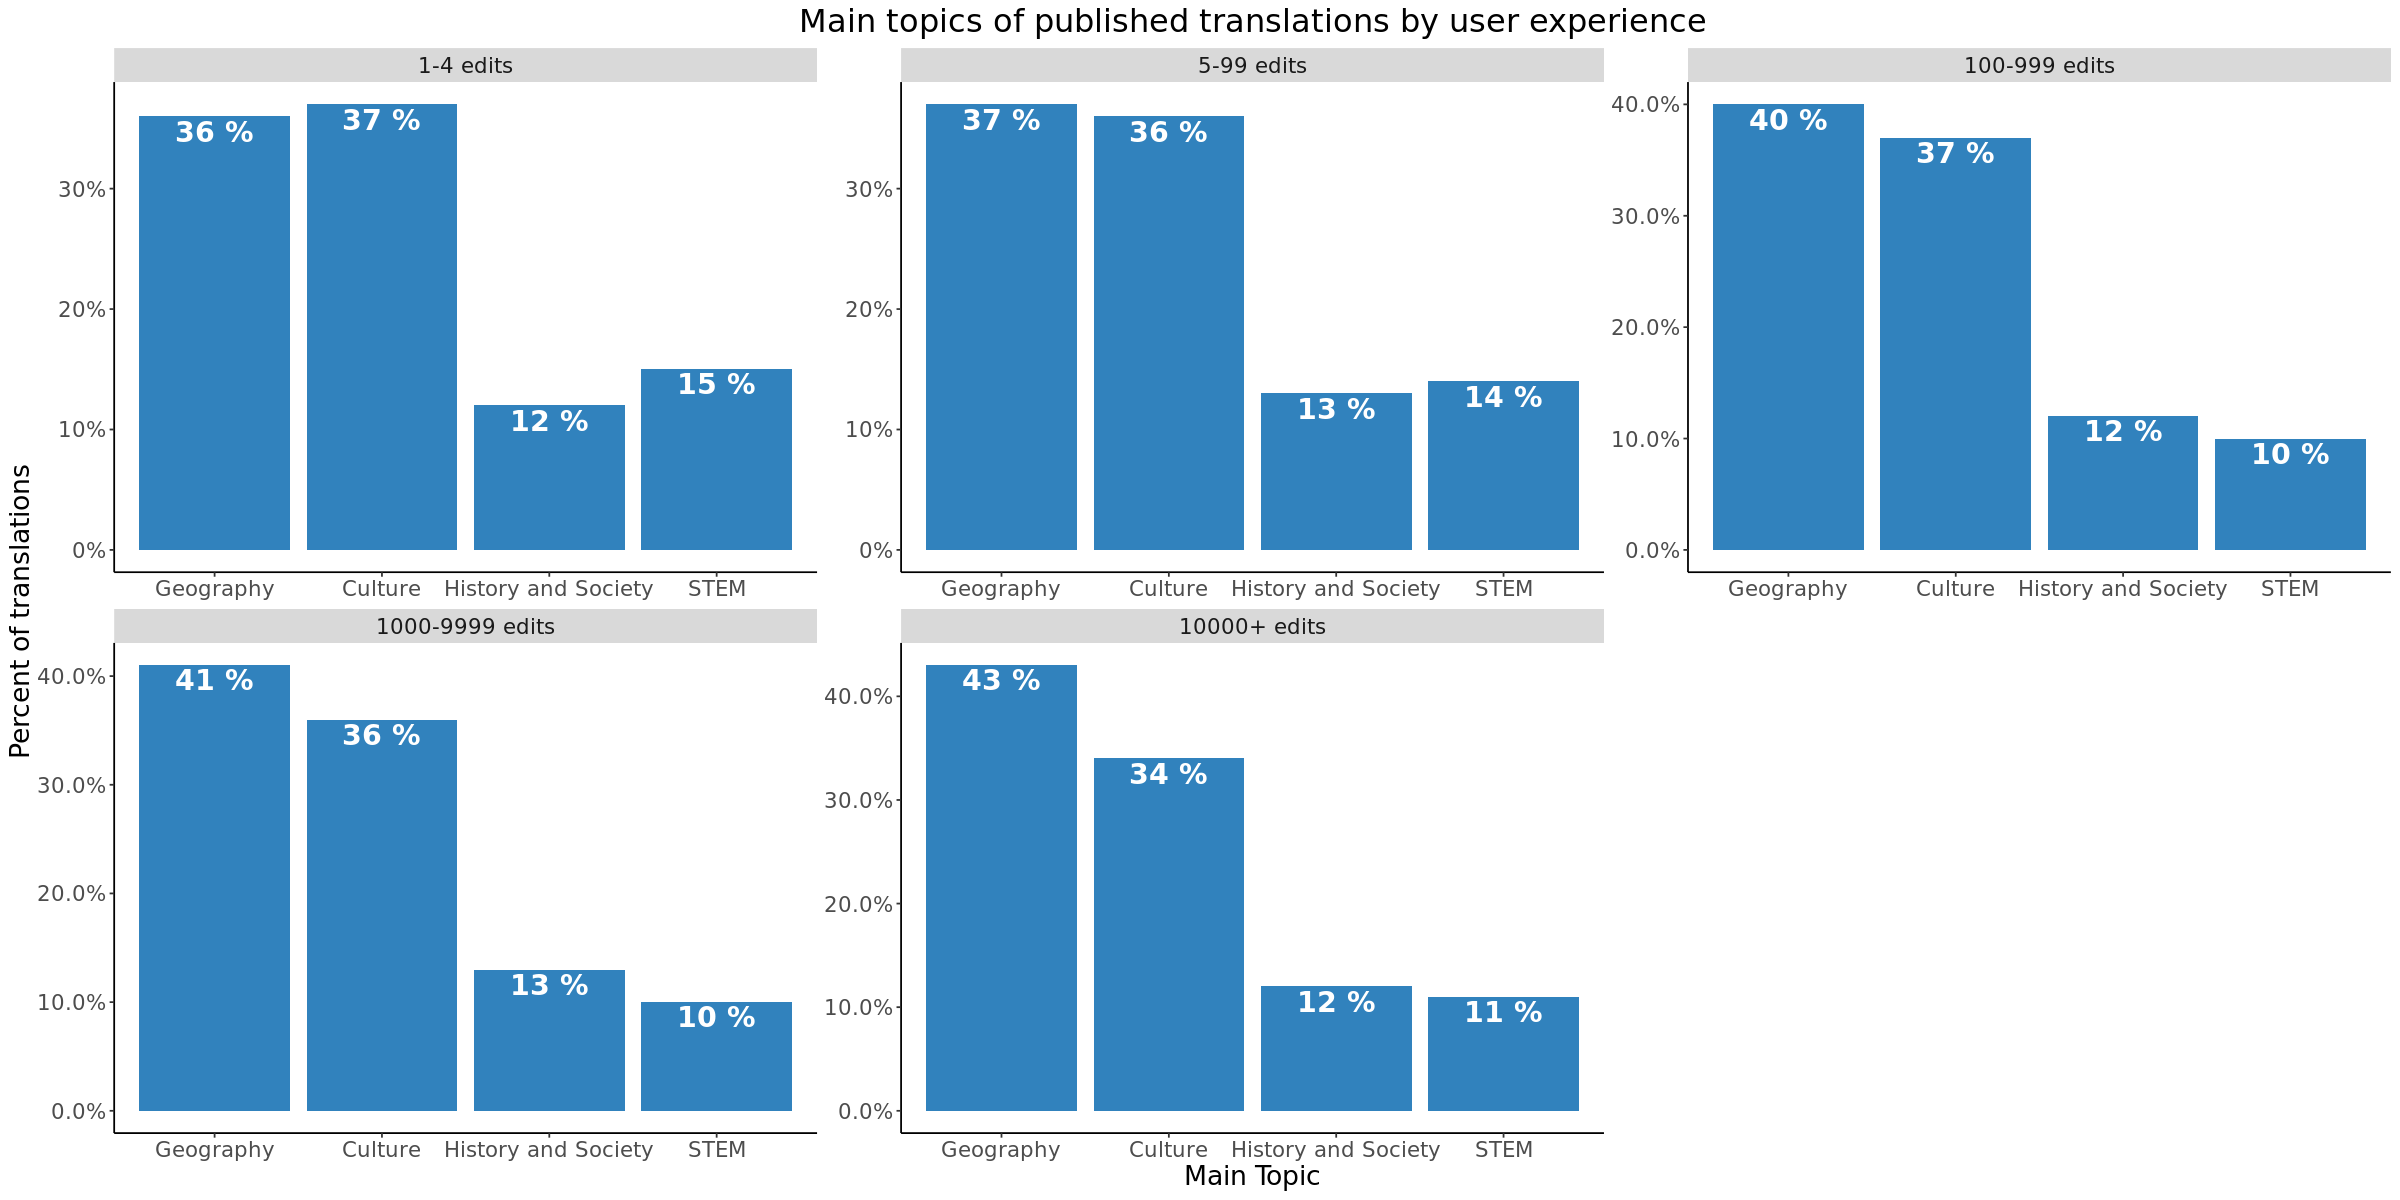

In [492]:
## Chart translation type by main topic and user experience

options(repr.plot.width = 20, repr.plot.height = 10)
# proportion of translations
p <- cx_maintopics_byuserexp   %>%
    ggplot(aes(x= main_topic, y = prop_translations)) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    facet_wrap(~ user_edit_count, scales = 'free') +
    geom_text(aes(label = paste(prop_translations * 100, "%"), fontface=2), vjust=1.2, size = 6, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Main Topic",
          title = "Main topics of published translations by user experience")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_maintopics_byuserexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

There are no significant differences in topic diversity across the different user edit count groups. There is a slightly higher percentage of STEM translated topics for more junior editors (under 100 edits).

## Topic diversity by sub topic and user experience

In [406]:
cx_topics_bysubtopic_userexp <- cx_topics_byuserexp %>%
    group_by(user_edit_count, sub_topic) %>%
    summarise(main_topic = first(main_topic),
        n_translations = n_distinct(revision_id)) %>%
   mutate(prop_translations = n_translations / sum(n_translations))  %>%
    arrange(desc(n_translations)) 


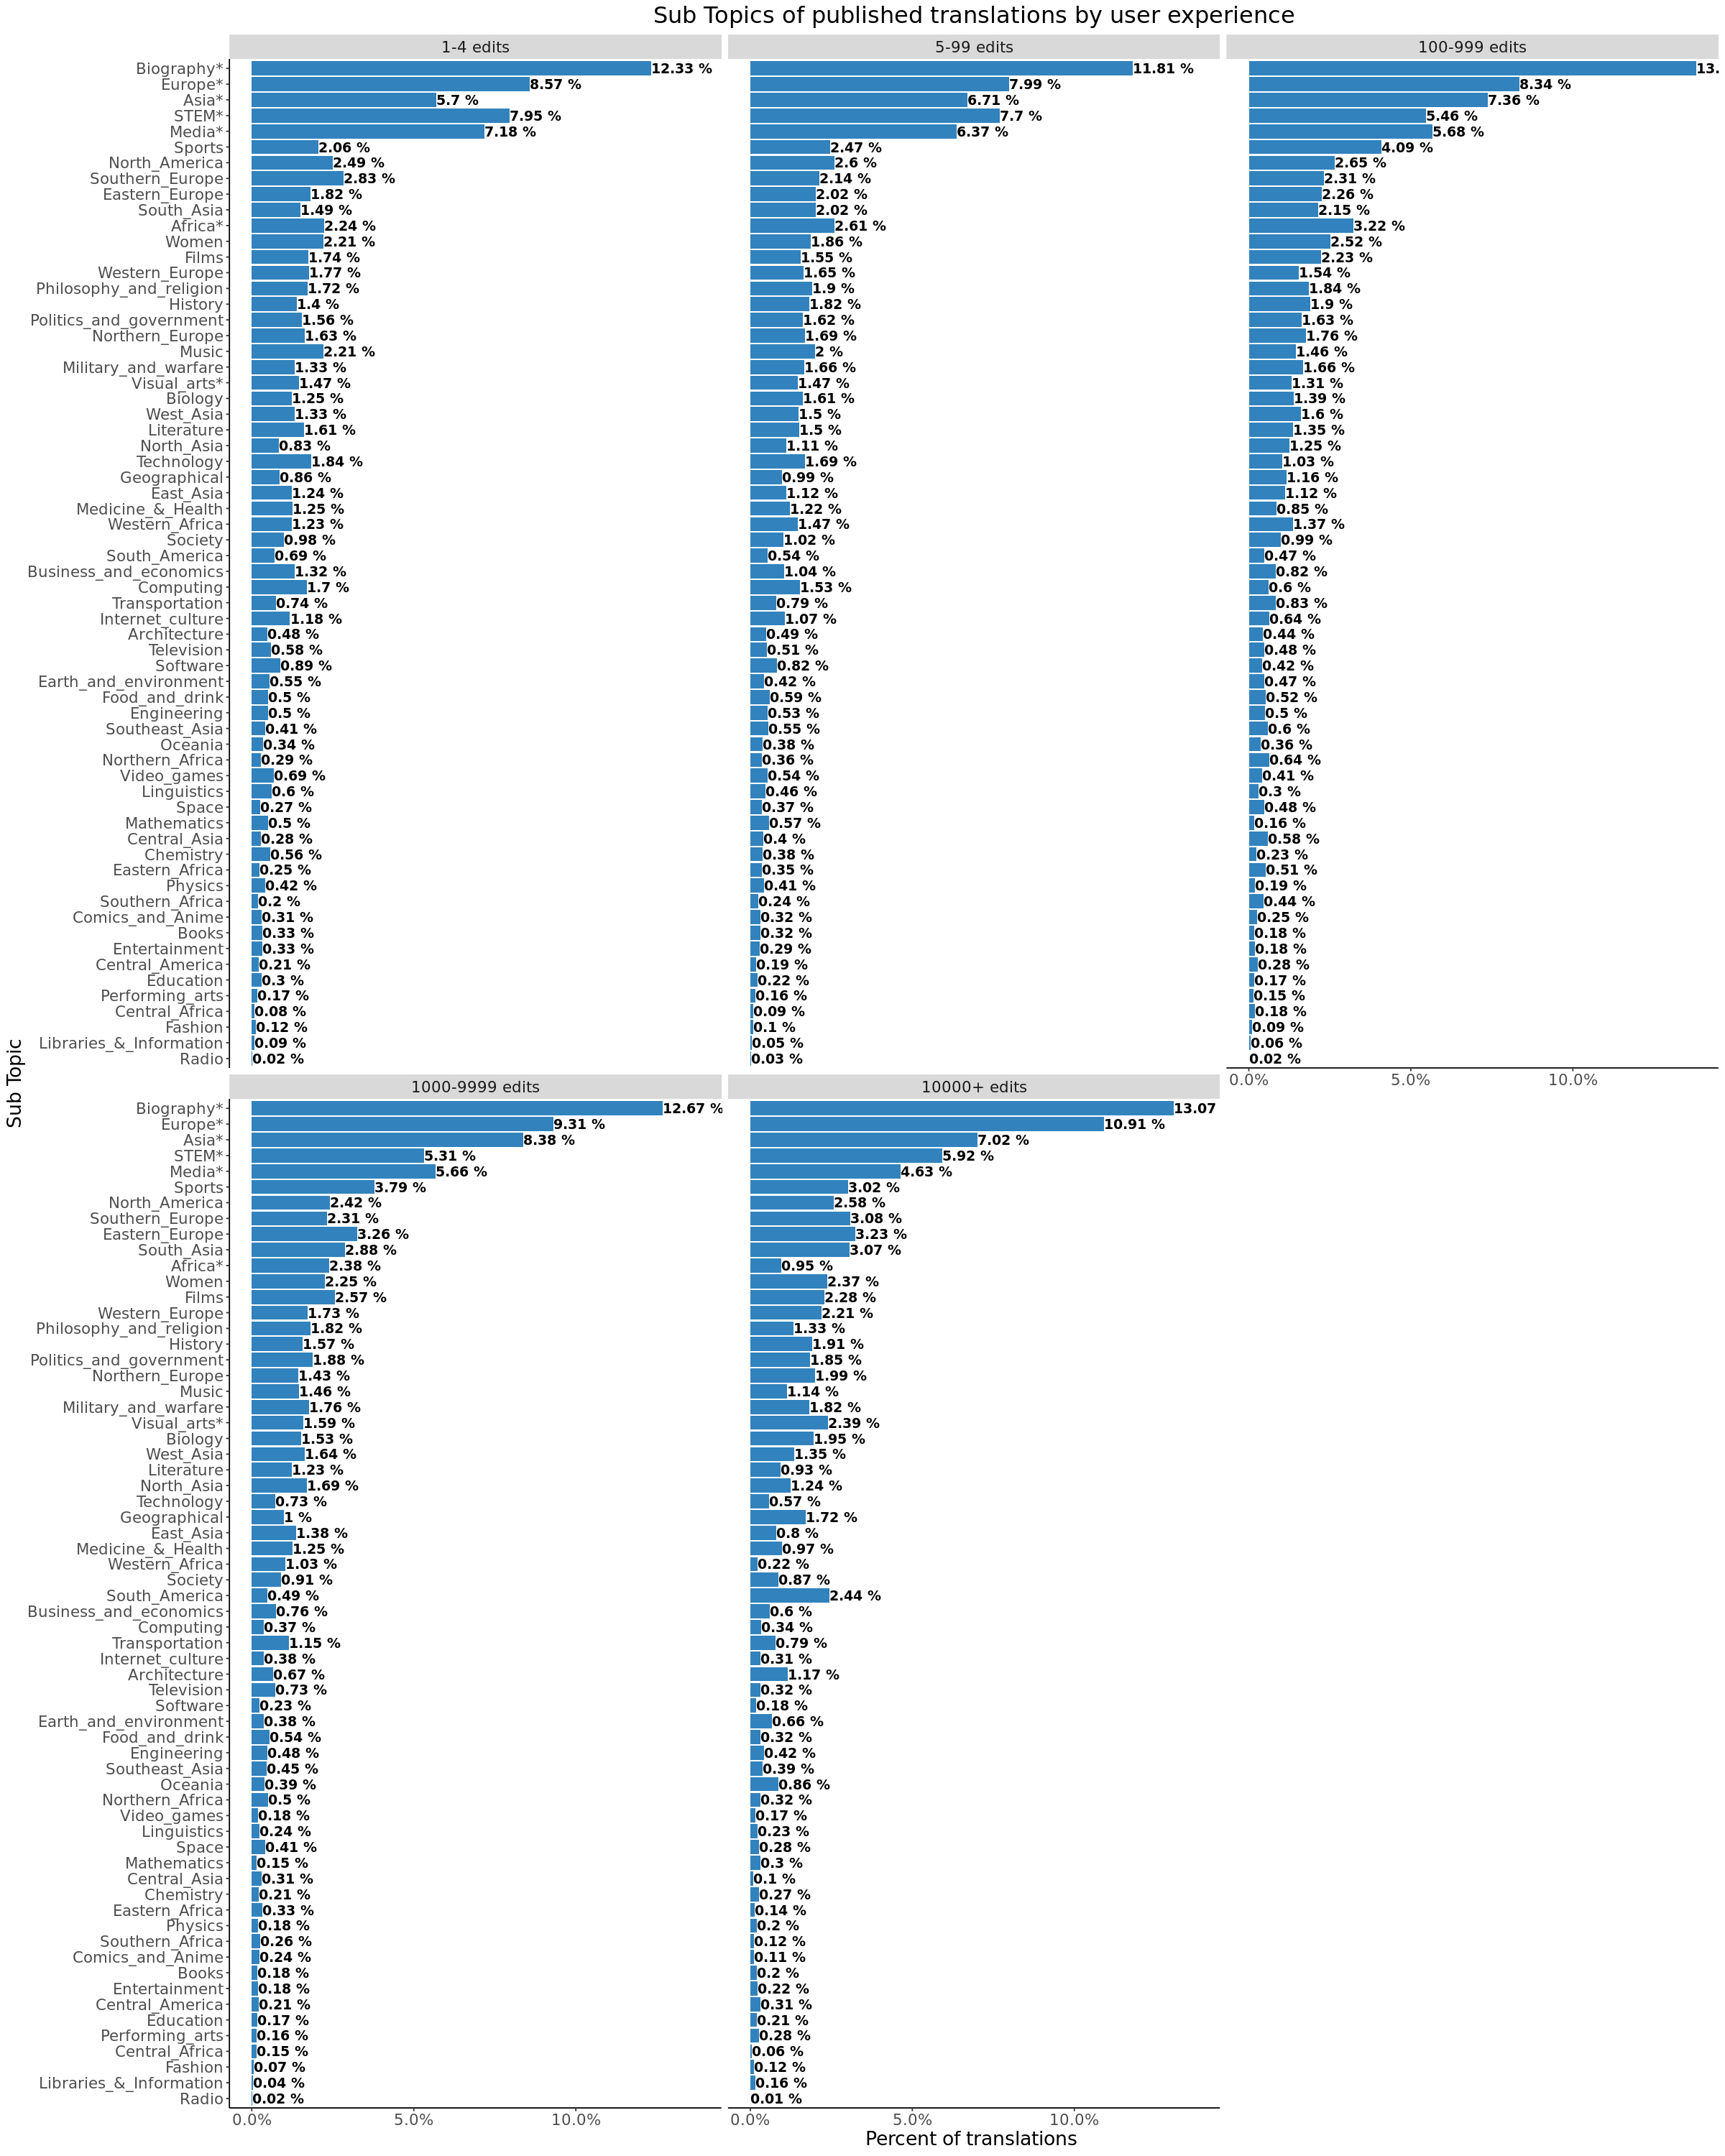

In [493]:
options(repr.plot.width = 20, repr.plot.height = 25)

# proportion of translations
p <- cx_topics_bysubtopic_userexp   %>%
   ggplot(aes(x= reorder(sub_topic, prop_translations), y = prop_translations)) +
    geom_col(position = 'dodge', fill = '#3182bd') +
    facet_wrap(~ user_edit_count)  +
    coord_flip() +
    geom_text(aes(label = paste(round(prop_translations * 100, 2), "%"), fontface=2), hjust=-0, size = 4, color = "black") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations ",
          x = "Sub Topic",
          title = "Sub Topics of published translations by user experience")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_topics_bysubtopic_userexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

# Topic Diversity by Language

Due to the large number of languages, data on the proportion of translations at each language by sub-topic was saved to this google [spreadsheet](https://docs.google.com/spreadsheets/d/1OLHIRY_Z4qmD6Xzm8TV_1JiWiH-fMAyZhXFq--1SeDI/edit#gid=83971368). This can be used to  filter and identify the proportion of published translations for each sub topic for any selected language(s).

I also reviewed the proportion of topics for languages identified as having low topic diversity. I identified these langauges as having over 60% of published translations in just one main topic and having over 15 translations during the reviewed timeframe. These requirements can be adjusted as needed.  

Let me know if there are other specific sets of languages that would be worth focusing on or any additional breakdowns that would be useful.  We may want to consider creating a Superset dashboard for this dataset if there is a need for more flexiblity in filtering and viewing data by a selected language.


## Translations by main topic for languages with lower topic diversity

Method: Identified any languages where over 60% of translations represented just one topic and that had more than 15 translated articles during the reviewed time period. These requirements can be adjusted as needed. 

In [431]:
# Look at top 10 languages for each main topic
cx_maintopics_bylang_low_diversity <- cx_topics_data %>%
    group_by( language, main_topic) %>%
    summarise(n_translations = n_distinct(revision_id)) %>%
    mutate(prop_translations = round(n_translations / sum(n_translations), 2))  %>%
    filter(prop_translations > .60 &
           n_translations > 15)

cx_maintopics_bylang_low_diversity

language main_topic n_translations prop_translations
1  bjnwiki  Geography    25           0.81             
2  kswiki   STEM        134           0.81             
3  kywiki   Geography   368           0.68             
4  mznwiki  Culture      19           0.63             
5  nqowiki  Geography   186           0.76             
6  nsowiki  Geography    24           0.83             
7  orwiki   STEM        554           0.70             
8  rwwiki   Geography   599           0.75             
9  tcywiki  Geography    21           0.66             
10 tlwiki   Geography  3017           0.87             
11 tnwiki   Geography    17           0.74             
12 tumwiki  Geography    39           0.95             
13 tyvwiki  Geography    85           0.82

There are 13 Wikipedias with lower topic diversity of translations compared to other languages. For the majority of these Wikipedias (10 wikis), most of the published translations are Geography topics. For Kyrgyx Wikipedia (kywiki) and Odia Wikipedia (orwiki), the majority of translation are STEM topics. For Mazanderani Wikipedia, most of the published translations within the last year have been Culture topics.

In [437]:
# create list of langauges
lang_low_diversity <- cx_maintopics_bylang_low_diversity$language


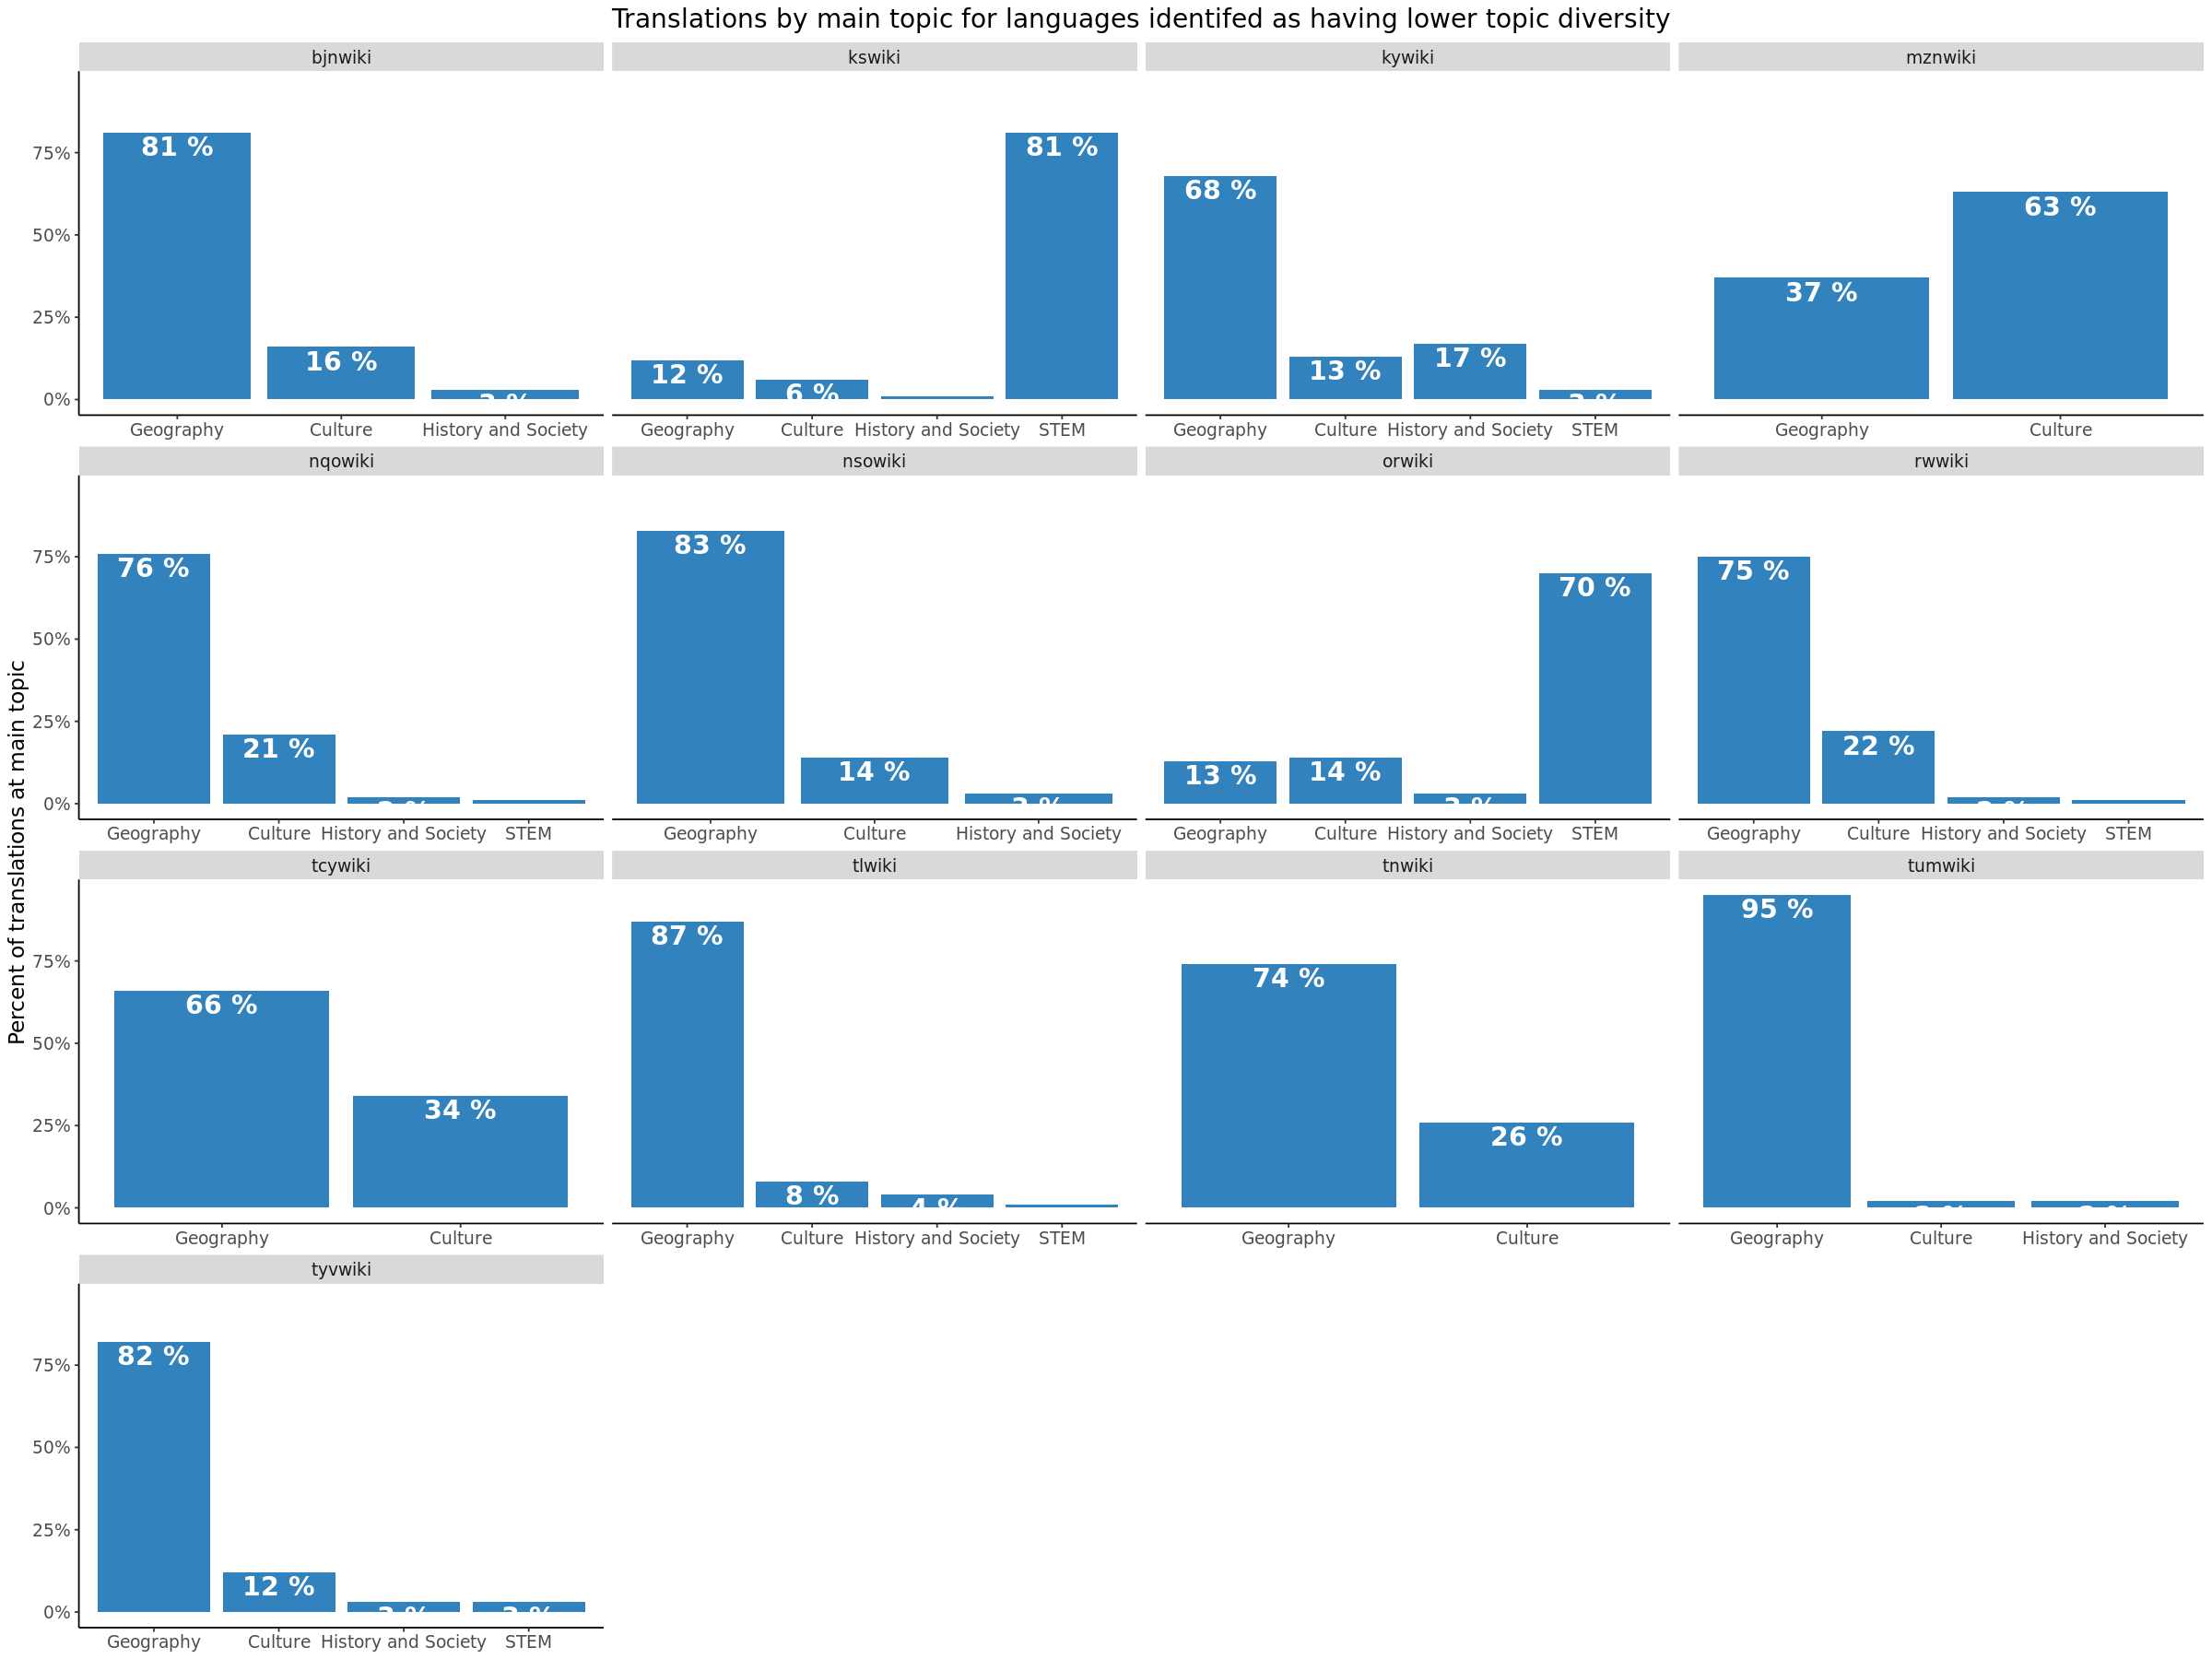

In [482]:
# Chart languages identifed as having low topic diversity

options(repr.plot.width = 20, repr.plot.height = 15)
# proportion of translations
p <- cx_topics_data  %>%
    filter(language %in% lang_low_diversity)  %>%
    group_by( language, main_topic) %>%
    summarise(n_translations = n_distinct(revision_id)) %>%
    mutate(prop_translations = round(n_translations / sum(n_translations), 2))  %>%
    ggplot(aes(x= main_topic, y = prop_translations)) +
    geom_col(position = position_dodge2(width = 0.9, preserve = "single"), fill = '#3182bd') +
    facet_wrap( ~ language , scales = "free_x", ncol = 4, nrow = 4) +
    geom_text(aes(label = paste(prop_translations * 100, "%"), fontface=2), vjust=1.2, size = 6, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of translations at main topic ",
          title = "Translations by main topic for languages identifed as having lower topic diversity")  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=14),
        axis.title.x=element_blank(),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/cx_maintopics_bylang_lowdiversity.png", p, width = 16, height = 8, units = "in", dpi = 300)

The above chart shows the published translations by main topic for all of the langauges identifed as having lower topic diversity. For at least seven of these wikis, all five main topics are represented in published translations. For the other six, there have been no published translations in at least one of the main topic categories in the past year.

## Topic diversity by languge and sub topic

Proportion of translations by language and sub topic available to view and filter at this google [spreadsheet](https://docs.google.com/spreadsheets/d/1OLHIRY_Z4qmD6Xzm8TV_1JiWiH-fMAyZhXFq--1SeDI/edit#gid=83971368).

In [ ]:
cx_topics_bylang <- cx_topics_data %>%
    group_by(language, sub_topic) %>%
    summarise(main_topic = first(main_topic),
        n_translations = n_distinct(revision_id))  %>%
    mutate(
    prop_translations = paste0(round(n_translations / sum(n_translations) * 100, 2), "%"))  %>%
    arrange(desc(prop_translations))
              

In [ ]:
# save by language data
write.csv(cx_topics_bylang,
    file = 'Data/cx_topics_bylang.csv',
    row.names = FALSE
  ) 
